# Combining it all

Here we will combine the approaches of all the past inversions. Here our the main steps we will follow:

1) create a true topography and synthetic observed gravity
2) create a starting model from the points of known topography (`constraints`) 
3) calculate a starting misfit
4) perform a damping parameter cross validation to determine the optimal damping value
5) use this damping value to perform a cross validation to find the optimal density and reference level values
6) create the weighting grid to help the inversion adhere to the constraints
7) perform a full final inversion constrained by the `weighting grid`, using the optimal damping, density, and reference level values. 


## Import packages

In [1]:
from __future__ import annotations

%load_ext autoreload
%autoreload 2
import logging
import pathlib
import pickle

import numpy as np
import pandas as pd
import verde as vd
import xarray as xr
from polartoolkit import maps
from polartoolkit import utils as polar_utils

from invert4geom import (
    cross_validation,
    inversion,
    optimization,
    plotting,
    regional,
    synthetic,
    uncertainty,
    utils,
)

# set up logging to see what's going on
logging.basicConfig(level=logging.INFO)

## Get Input datasets

In [4]:
# set grid parameters
spacing = 1000
region = (0, 40000, 0, 30000)

(
    true_topography,
    _,
    _,
    _,
) = synthetic.load_synthetic_model(
    spacing=spacing,
    region=region,
    topography_coarsen_factor=2,
    topography_percent_noise=0.02,
)

# create lower synthetic topography data
lower_topography = synthetic.synthetic_topography_regional(
    spacing,
    region,
    scale=1,
    yoffset=-1000,
)

true_zref = true_topography.values.mean()
print(f"mean of true topography: {true_zref} m ")

INFO:invert4geom:Standard deviation used for noise: [14.371030389252887]


mean of true topography: 492.2589625197673 m 


MESA: error: ZINK: failed to choose pdev
glx: failed to create drisw screen


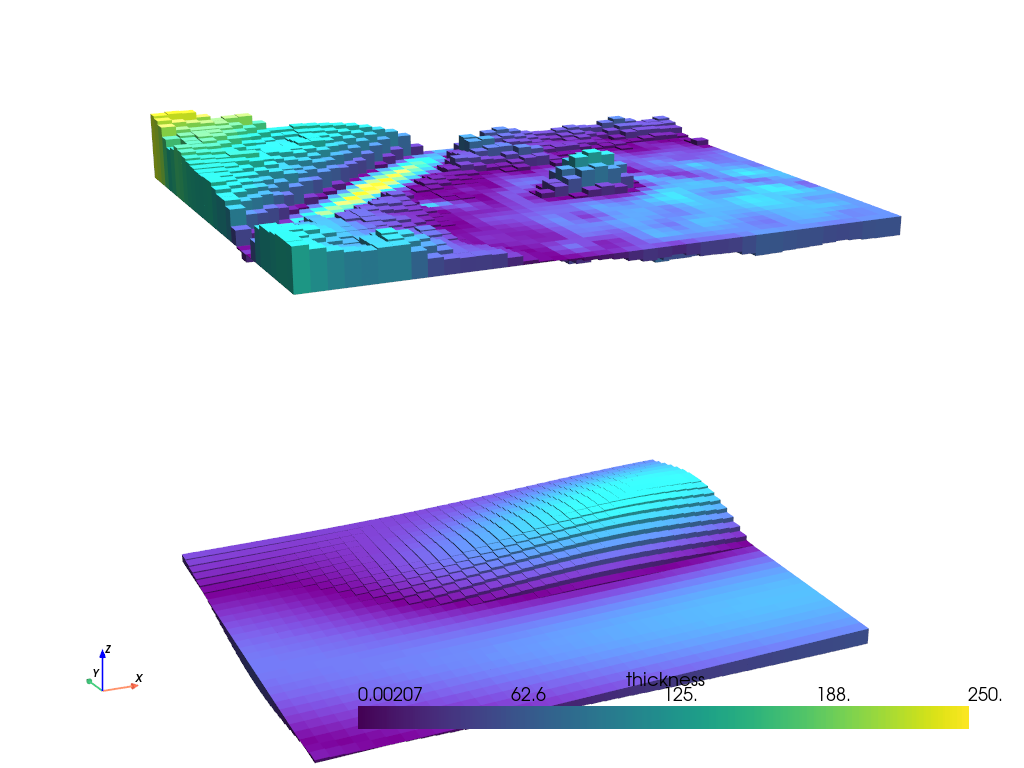

mean topography is 492.2589625197673 m


In [5]:
# the density contrast is between rock (~2670 kg/m3) and air (~1 kg/m3)
true_density_contrast = 2670 - 1

# prisms are created between the mean topography value and the height of the topography
true_zref = true_topography.values.mean()

# prisms above zref have positive density contrast and prisms below zref have negative
# density contrast
density_grid = xr.where(
    true_topography >= true_zref,
    true_density_contrast,
    -true_density_contrast,
)

# create layer of prisms
prisms = utils.grids_to_prisms(
    true_topography,
    true_zref,
    density=density_grid,
)

# the density contrast is between lower crust (~3100 kg/m3) and rock (~2670 kg/m3)
density_contrast = 3100 - 2670
zref = lower_topography.values.mean()

density_grid = xr.where(lower_topography >= zref, density_contrast, -density_contrast)
lower_prisms = utils.grids_to_prisms(
    lower_topography,
    zref,
    density=density_grid,
)

plotting.show_prism_layers(
    [prisms, lower_prisms],
    color_by="thickness",
    log_scale=False,
    zscale=20,
    backend="static",
)

print(f"mean topography is {prisms.attrs.get("zref")} m")

In [4]:
# make pandas dataframe of locations to calculate gravity
# this represents the station locations of a gravity survey
# create lists of coordinates
coords = vd.grid_coordinates(
    region=region,
    spacing=spacing,
    pixel_register=False,
    extra_coords=1001,  # survey elevation
)

# grid the coordinates
observations = vd.make_xarray_grid(
    (coords[0], coords[1]),
    data=coords[2],
    data_names="upward",
    dims=("northing", "easting"),
).upward

grav_df = vd.grid_to_table(observations)

grav_df["upper_surface_grav"] = prisms.prism_layer.gravity(
    coordinates=(
        grav_df.easting,
        grav_df.northing,
        grav_df.upward,
    ),
    field="g_z",
    progressbar=True,
)

# forward gravity of lower surface prisms
grav_df["lower_surface_grav"] = lower_prisms.prism_layer.gravity(
    coordinates=(
        grav_df.easting,
        grav_df.northing,
        grav_df.upward,
    ),
    field="g_z",
    progressbar=True,
)

grav_df["observed_grav"] = grav_df.upper_surface_grav + grav_df.lower_surface_grav
grav_df

  0%|                                                      | 0/1271 [00:00<?, ?it/s]

  0%|                                                      | 0/1271 [00:00<?, ?it/s]

,northing,easting,upward,upper_surface_grav,lower_surface_grav,observed_grav
0,0.0,0.0,1001.0,9.042402,-0.041223,9.001179
1,0.0,1000.0,1001.0,9.568091,-0.052122,9.515969
2,0.0,2000.0,1001.0,8.893385,-0.068787,8.824597
3,0.0,3000.0,1001.0,8.340538,-0.088267,8.252271
4,0.0,4000.0,1001.0,8.106203,-0.108803,7.997400
...,...,...,...,...,...,...
1266,30000.0,36000.0,1001.0,4.192357,0.658225,4.850582
1267,30000.0,37000.0,1001.0,3.673730,0.641455,4.315185
1268,30000.0,38000.0,1001.0,2.982330,0.607664,3.589994
1269,30000.0,39000.0,1001.0,2.946999,0.545480,3.492479


In [5]:
# contaminate gravity with 0.1 mGal of random noise
grav_df["gravity_anomaly"], stddev = synthetic.contaminate(
    grav_df.observed_grav,
    stddev=0.1,
    percent=False,
    seed=0,
)
grav_df["uncert"] = stddev

INFO:invert4geom:Standard deviation used for noise: [0.1]


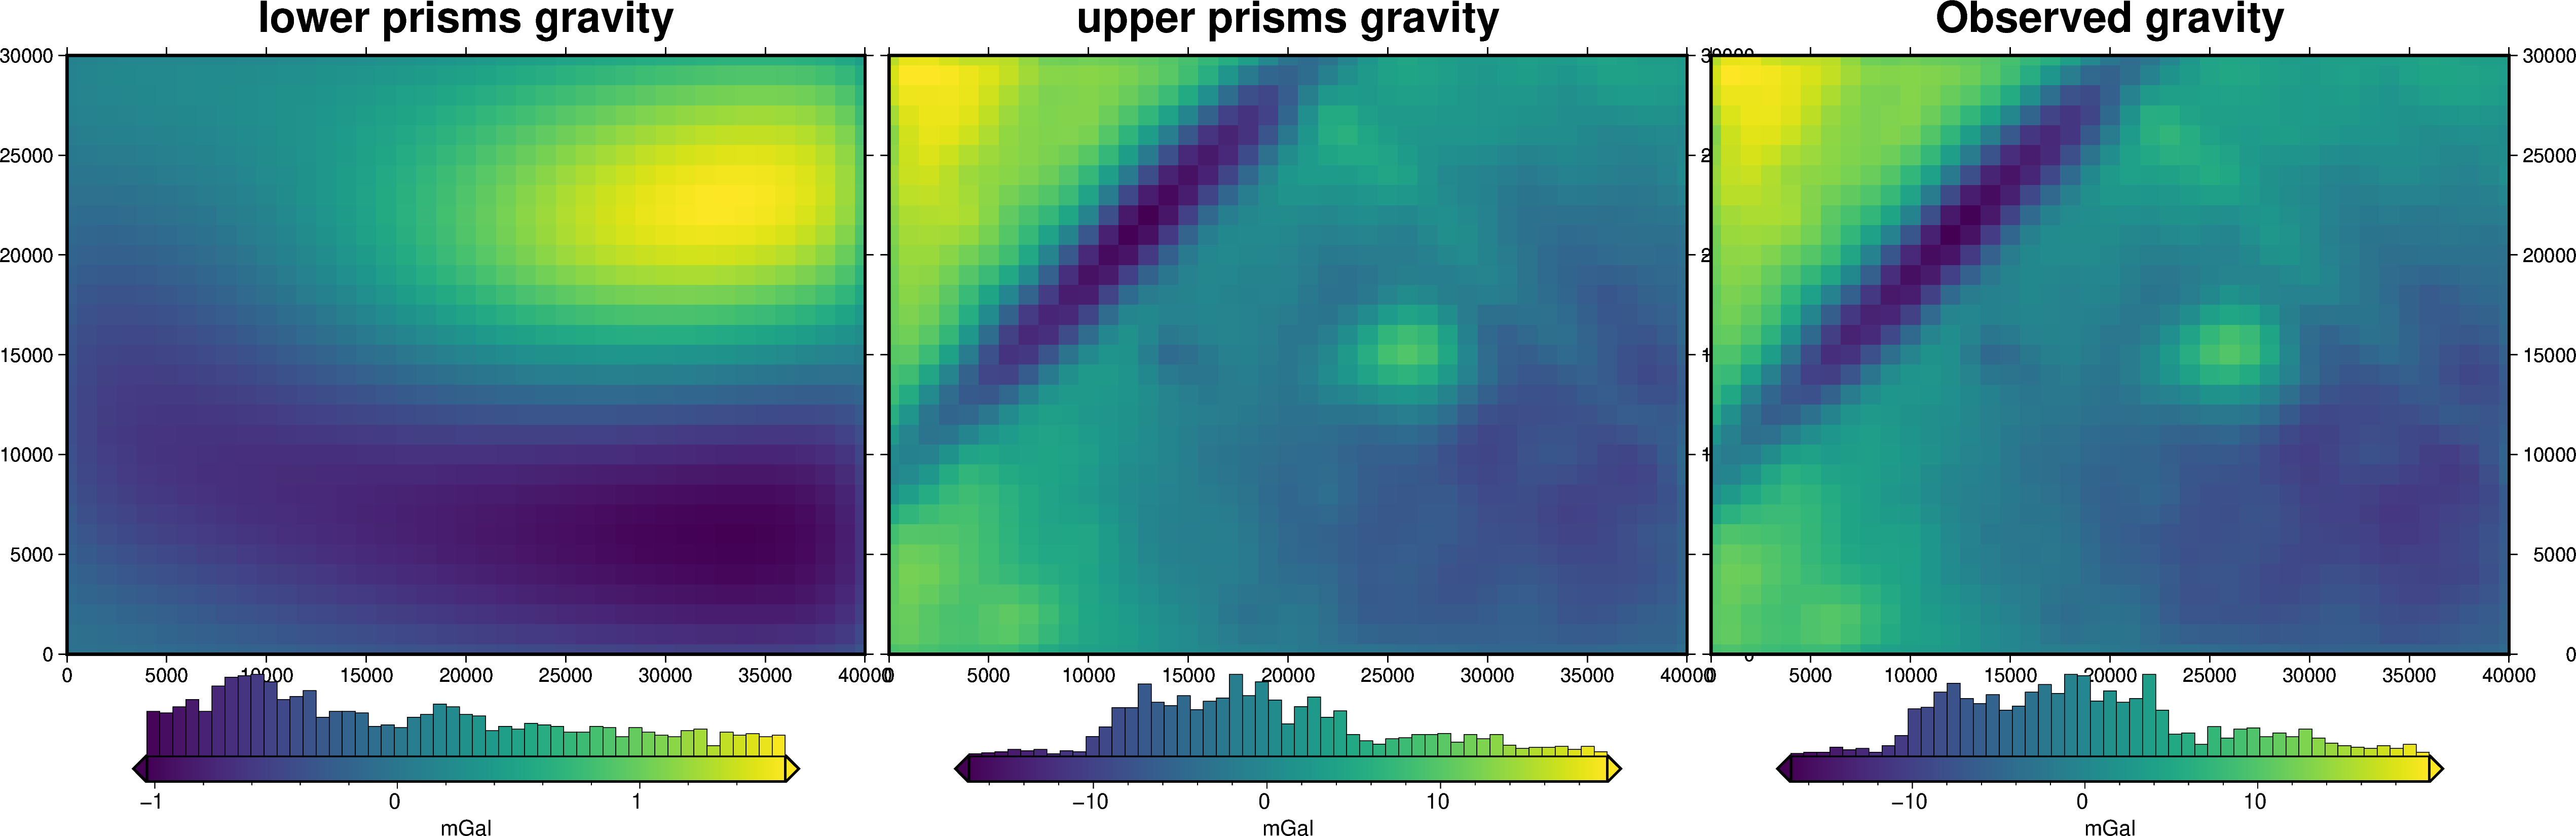

In [6]:
grav_grid = grav_df.set_index(["northing", "easting"]).to_xarray()

fig = maps.plot_grd(
    grav_grid.lower_surface_grav,
    fig_height=10,
    title="lower prisms gravity",
    cmap="viridis",
    hist=True,
    cbar_label="mGal",
    frame=["nSWe", "xaf10000", "yaf10000"],
)

fig = maps.plot_grd(
    grav_grid.upper_surface_grav,
    fig=fig,
    origin_shift="x",
    fig_height=10,
    title="upper prisms gravity",
    cmap="viridis",
    hist=True,
    cbar_label="mGal",
    frame=["nSwE", "xaf10000", "yaf10000"],
)

fig = maps.plot_grd(
    grav_grid.gravity_anomaly,
    fig=fig,
    origin_shift="x",
    fig_height=10,
    title="Observed gravity",
    cmap="viridis",
    hist=True,
    cbar_label="mGal",
    frame=["nSwE", "xaf10000", "yaf10000"],
)

fig.show()

## Create "a-priori" topography measurements

In [7]:
# create 15 random point within the outcropping basement region
num_constraints = 15
coords = vd.scatter_points(
    region=vd.pad_region(region, -spacing),
    size=num_constraints,
    random_state=7,
)
constraint_points = pd.DataFrame(data={"easting": coords[0], "northing": coords[1]})

# sample true topography at these points
constraint_points = utils.sample_grids(
    constraint_points,
    true_topography,
    "true_upward",
)

constraint_points["upward"] = constraint_points.true_upward
constraint_points.head()

,easting,northing,true_upward,upward
0,3899.714996,26468.618776,666.725645,666.725645
1,30636.914105,6974.789900,406.379413,406.379413
2,17659.550795,13659.470931,480.393921,480.393921
3,28491.676758,27073.768551,517.183455,517.183455
4,38163.601456,1697.178371,435.459979,435.459979


In [8]:
# re-sample depths with uncertainty to emulate measurement errors
# set each points uncertainty equal to 2% of depth
uncert = np.abs(0.02 * constraint_points.upward)
constraint_points.loc[constraint_points.index, "uncert"] = uncert

constraint_points = uncertainty.randomly_sample_data(
    seed=0,
    data_df=constraint_points,
    data_col="upward",
    uncert_col="uncert",
)

# create weights column
constraint_points["weight"] = 1 / (constraint_points.uncert**2)

constraint_points.head()

,easting,northing,true_upward,upward,uncert,weight
0,3899.714996,26468.618776,666.725645,668.402196,13.334513,0.005624
1,30636.914105,6974.789900,406.379413,405.305719,8.127588,0.015138
2,17659.550795,13659.470931,480.393921,486.547024,9.607878,0.010833
3,28491.676758,27073.768551,517.183455,518.268507,10.343669,0.009347
4,38163.601456,1697.178371,435.459979,430.794727,8.709200,0.013184


## Create starting model

INFO:invert4geom:Best SplineCV score: 0.6403721398726441


INFO:invert4geom:Best damping: 1.3530477745797964e-07


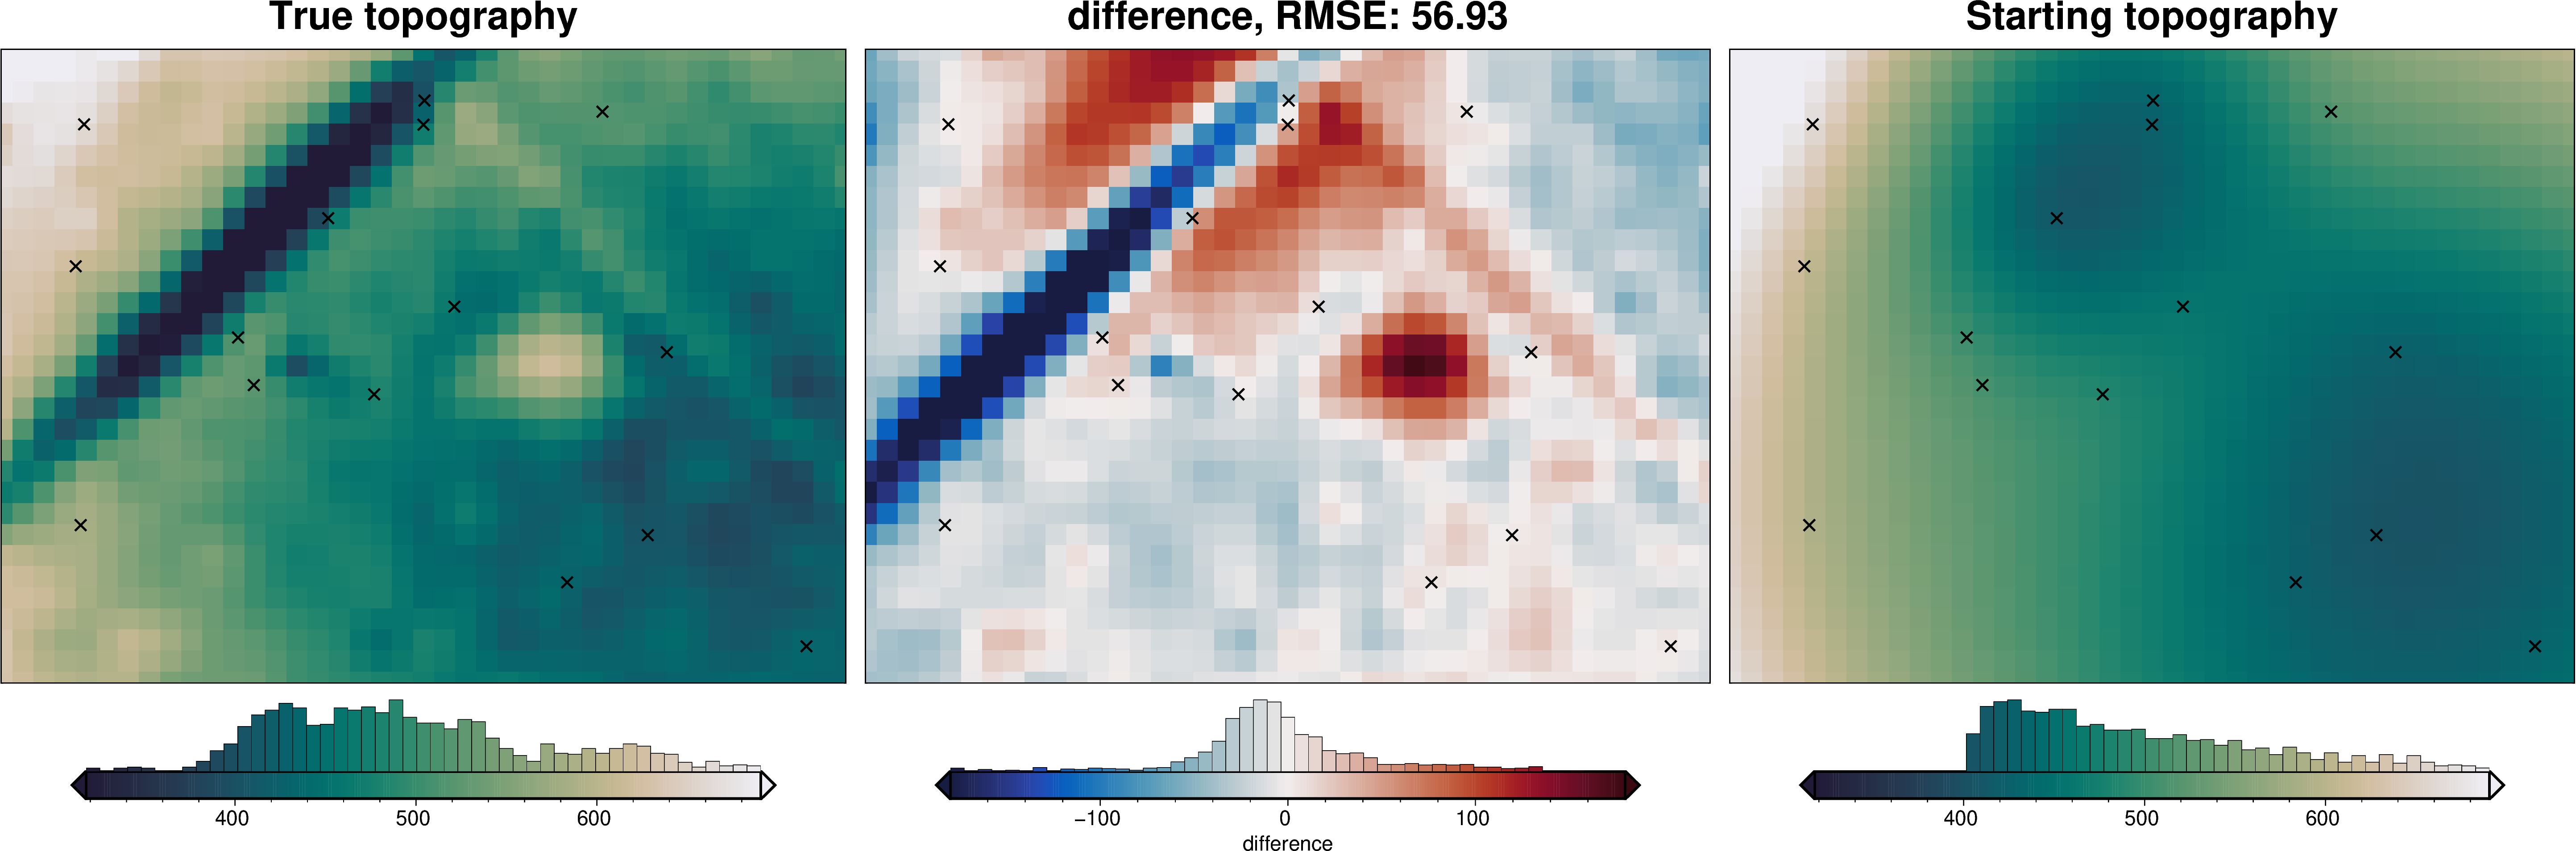

In [9]:
# grid the sampled values using verde
starting_topography_kwargs = dict(
    method="splines",
    region=region,
    spacing=spacing,
    constraints_df=constraint_points,
    dampings=np.logspace(-40, 0, 100),
    weights_col="weight",
)

starting_topography = utils.create_topography(**starting_topography_kwargs)

_ = polar_utils.grd_compare(
    true_topography,
    starting_topography,
    region=region,
    grid1_name="True topography",
    grid2_name="Starting topography",
    robust=True,
    hist=True,
    title="difference",
    grounding_line=False,
    reverse_cpt=True,
    cmap="rain",
    points=constraint_points,
    points_style="x.3c",
)

MESA: error: ZINK: failed to choose pdev
glx: failed to create drisw screen


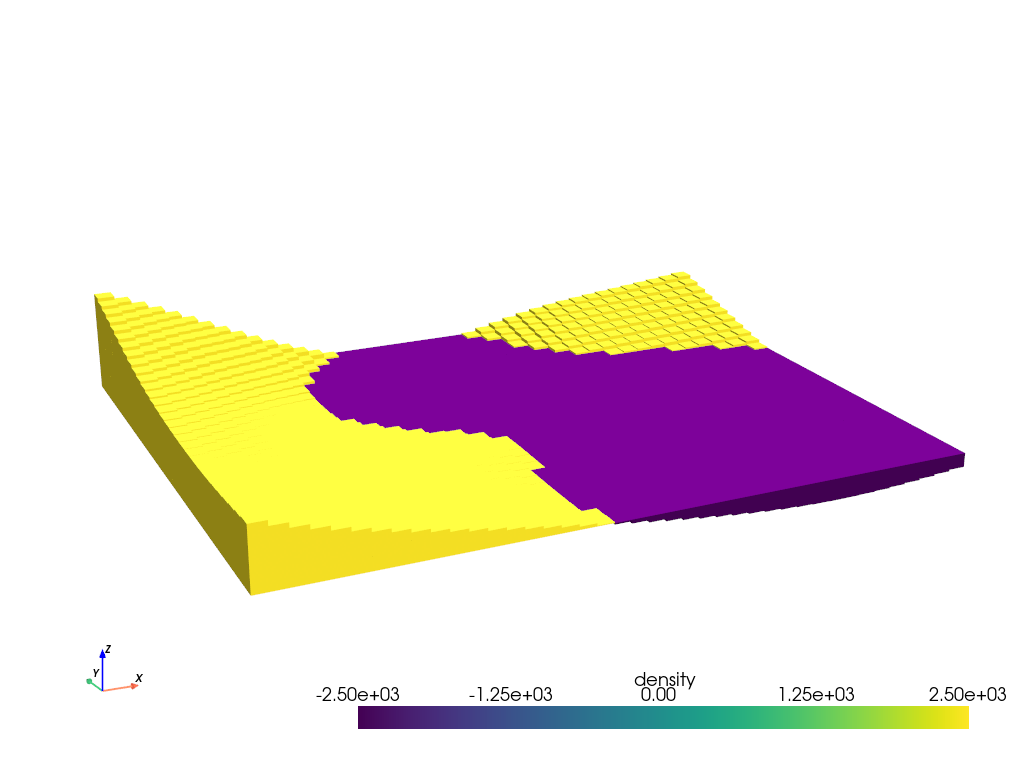

In [10]:
# the true zref value is 492 m
zref = constraint_points.upward.mean()

# the true density contrast is 2669 kg/m3
density_contrast = 2500

# prisms above zref have positive density contrast and prisms below zref have negative
# density contrast
density_grid = xr.where(
    starting_topography >= zref, density_contrast, -density_contrast
)

# create layer of prisms
starting_prisms = utils.grids_to_prisms(
    starting_topography,
    zref,
    density=density_grid,
)
plotting.show_prism_layers(
    starting_prisms,
    color_by="density",
    log_scale=False,
    zscale=20,
    backend="static",
)

## Calculate starting gravity misfit 
Now we need to calculate the forward gravity of the starting topography. We then can subtract it from our observed gravity to get a starting gravity misfit.

We don't know the optimal values for the density contrast or the reference level, so we will make a guess at appropriate values for the starting model.

In [11]:
# calculate forward gravity of starting prism layer
grav_df["starting_gravity"] = starting_prisms.prism_layer.gravity(
    coordinates=(
        grav_df.easting,
        grav_df.northing,
        grav_df.upward,
    ),
    field="g_z",
    progressbar=True,
)

# calculate the true residual misfit
grav_df["true_res"] = (
    grav_df.gravity_anomaly - grav_df.starting_gravity - grav_df.lower_surface_grav
)

grav_df.describe()

  0%|                                                      | 0/1271 [00:00<?, ?it/s]

,northing,easting,upward,upper_surface_grav,lower_surface_grav,observed_grav,gravity_anomaly,uncert,starting_gravity,true_res
count,1271.000000,1271.00000,1271.0,1271.000000,1271.000000,1271.000000,1271.000000,1.271000e+03,1271.000000,1271.000000
mean,15000.000000,20000.00000,1001.0,-0.128924,0.004007,-0.124917,-0.124917,1.000000e-01,1.130048,-1.258972
std,8947.792584,11836.81698,0.0,7.128555,0.714063,7.271000,7.269461,2.776650e-17,6.906876,4.602393
min,0.000000,0.00000,1001.0,-17.179165,-1.033526,-16.887668,-17.040892,1.000000e-01,-8.029374,-19.592048
25%,7000.000000,10000.00000,1001.0,-5.448852,-0.601914,-5.750137,-5.739415,1.000000e-01,-4.384273,-3.001265
50%,15000.000000,20000.00000,1001.0,-1.160222,-0.153040,-0.758131,-0.713654,1.000000e-01,-0.620986,-1.444045
75%,23000.000000,30000.00000,1001.0,3.675021,0.541706,3.825804,3.815224,1.000000e-01,5.463603,0.461464
max,30000.000000,40000.00000,1001.0,19.599674,1.599823,19.781652,19.936108,1.000000e-01,23.315668,13.969990


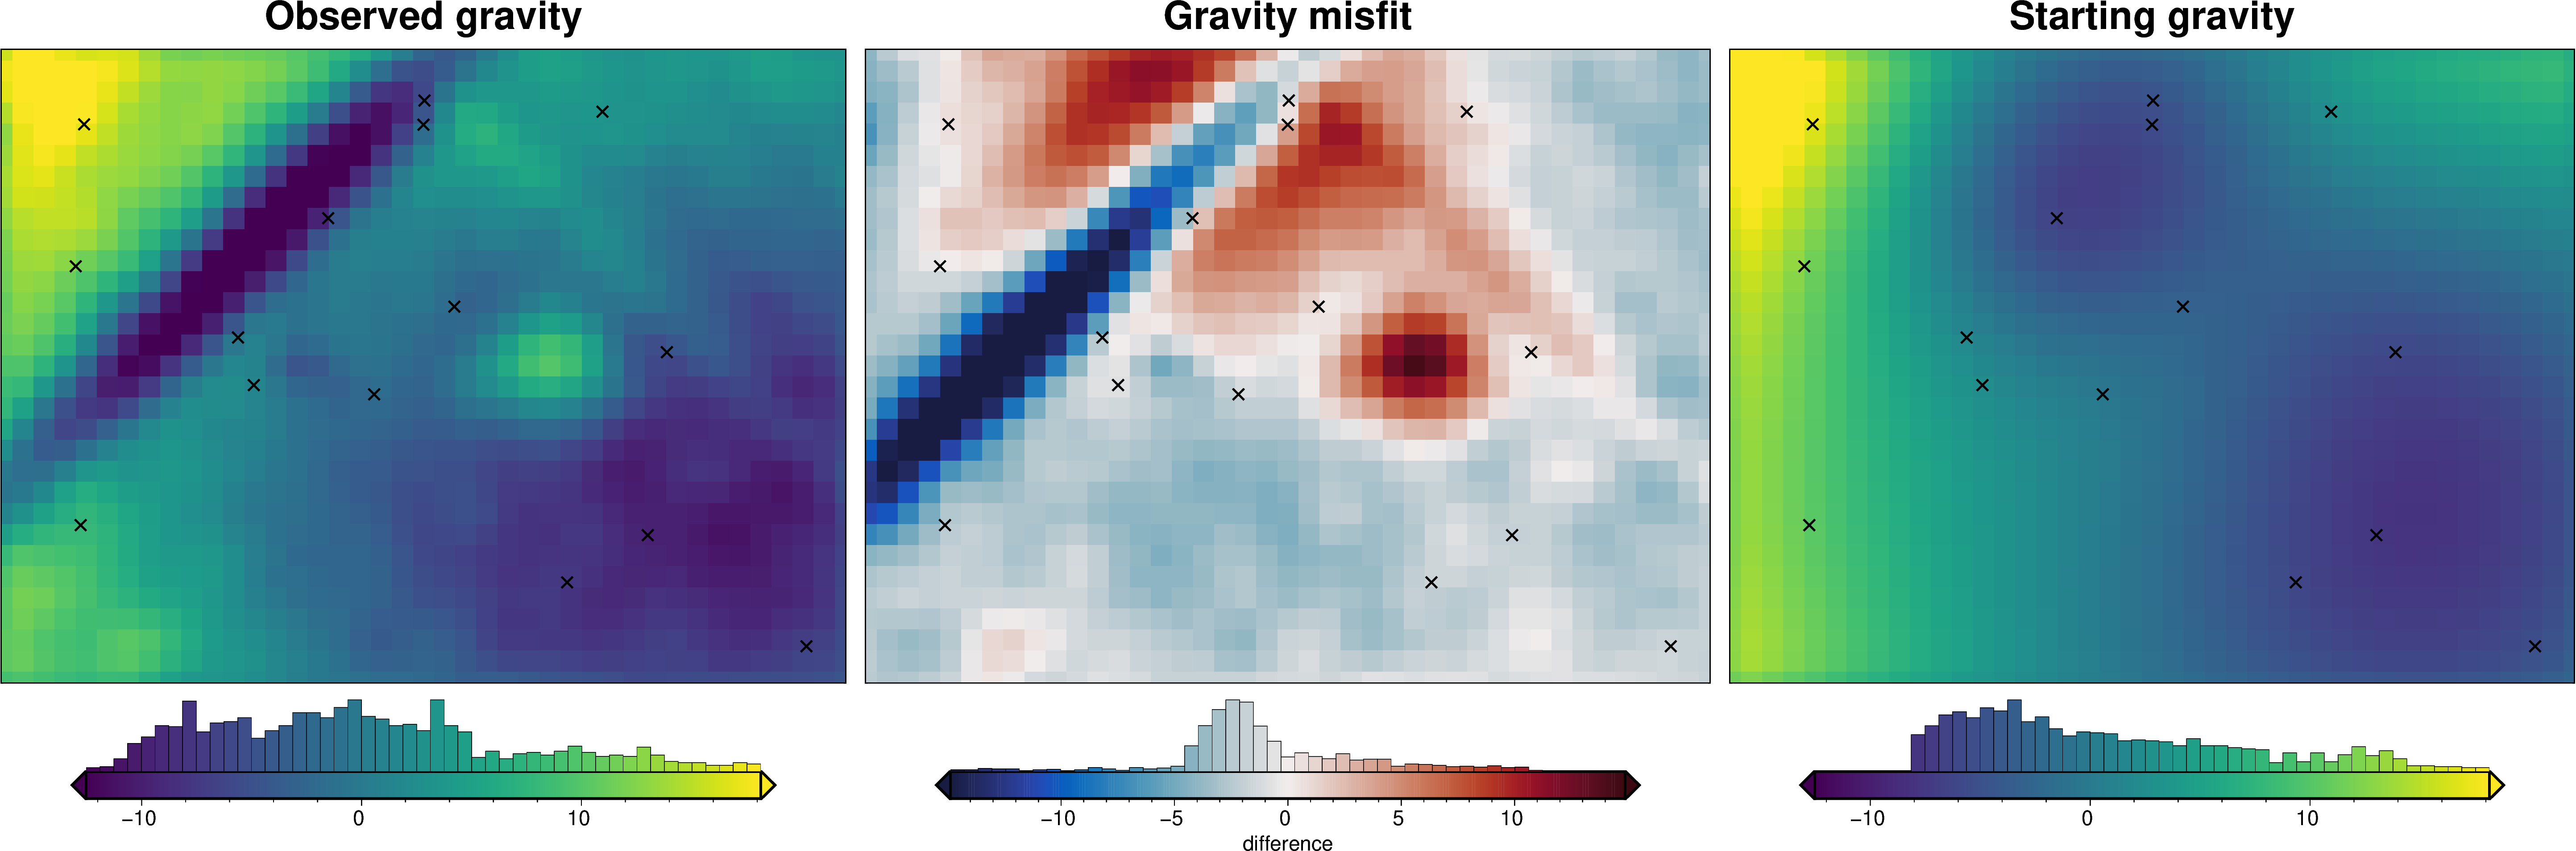

In [12]:
# grid the results
grav_grid = grav_df.set_index(["northing", "easting"]).to_xarray()

_ = polar_utils.grd_compare(
    grav_grid.gravity_anomaly,
    grav_grid.starting_gravity,
    grid1_name="Observed gravity",
    grid2_name="Starting gravity",
    robust=True,
    hist=True,
    title="Gravity misfit",
    rmse_in_title=False,
    grounding_line=False,
    points=constraint_points,
    points_style="x.3c",
)

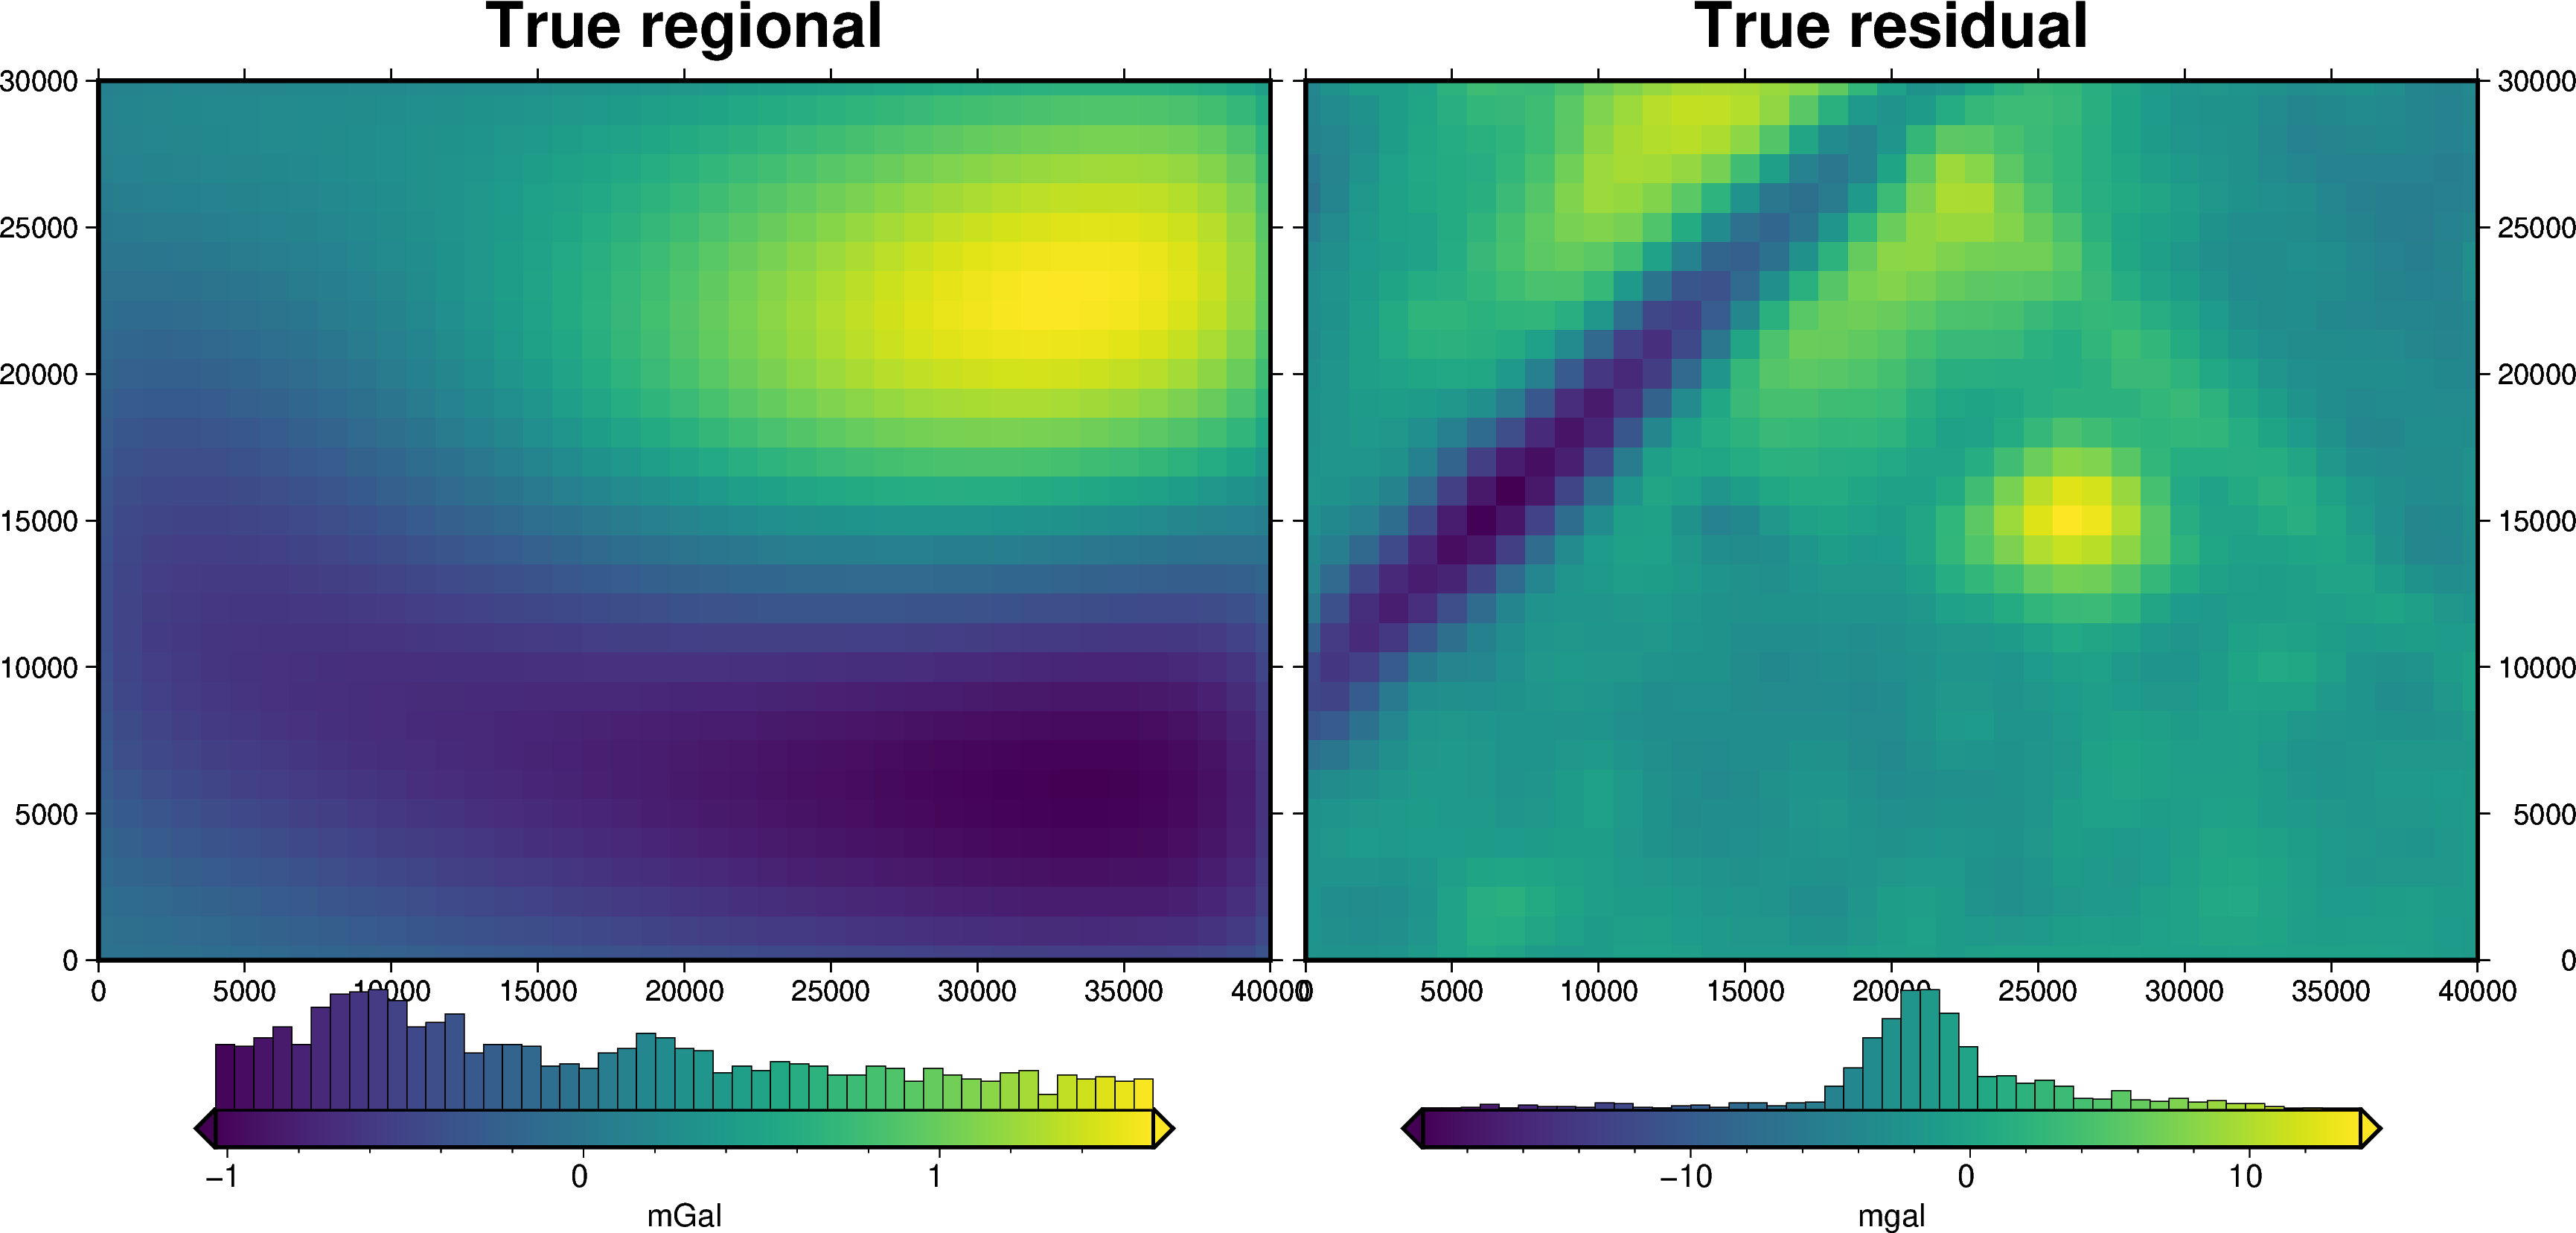

In [13]:
fig = maps.plot_grd(
    grav_grid.lower_surface_grav,
    fig_height=10,
    title="True regional",
    hist=True,
    cbar_label="mGal",
    frame=["nSWe", "xaf10000", "yaf10000"],
)

fig = maps.plot_grd(
    grav_grid.true_res,
    fig=fig,
    origin_shift="x",
    fig_height=10,
    title="True residual",
    hist=True,
    cbar_label="mgal",
    frame=["nSwE", "xaf10000", "yaf10000"],
)

fig.show()

## Regional separation

In [14]:
def regional_comparison(df):
    # grid the results
    grav_grid = df.set_index(["northing", "easting"]).to_xarray()

    # compare with true regional
    _ = polar_utils.grd_compare(
        grav_grid.lower_surface_grav,
        grav_grid.reg,
        robust=True,
        grid1_name="True regional field",
        grid2_name="Estimated regional field",
        hist=True,
        title="difference",
        grounding_line=False,
        points=constraint_points,
        points_style="x.3c",
    )
    # compare with true residual
    _ = polar_utils.grd_compare(
        grav_grid.true_res,
        grav_grid.res,
        robust=True,
        grid1_name="True residual field",
        grid2_name="Estimated residual field",
        hist=True,
        title="difference",
        grounding_line=False,
        points=constraint_points,
        points_style="x.3c",
    )

INFO:invert4geom:using 12 startup trials


INFO:invert4geom:Trial with best score: 


INFO:invert4geom:	trial number: 44


INFO:invert4geom:	parameter: {'damping': 0.0007636888528220723}


INFO:invert4geom:	scores: [-0.26136694121087156]


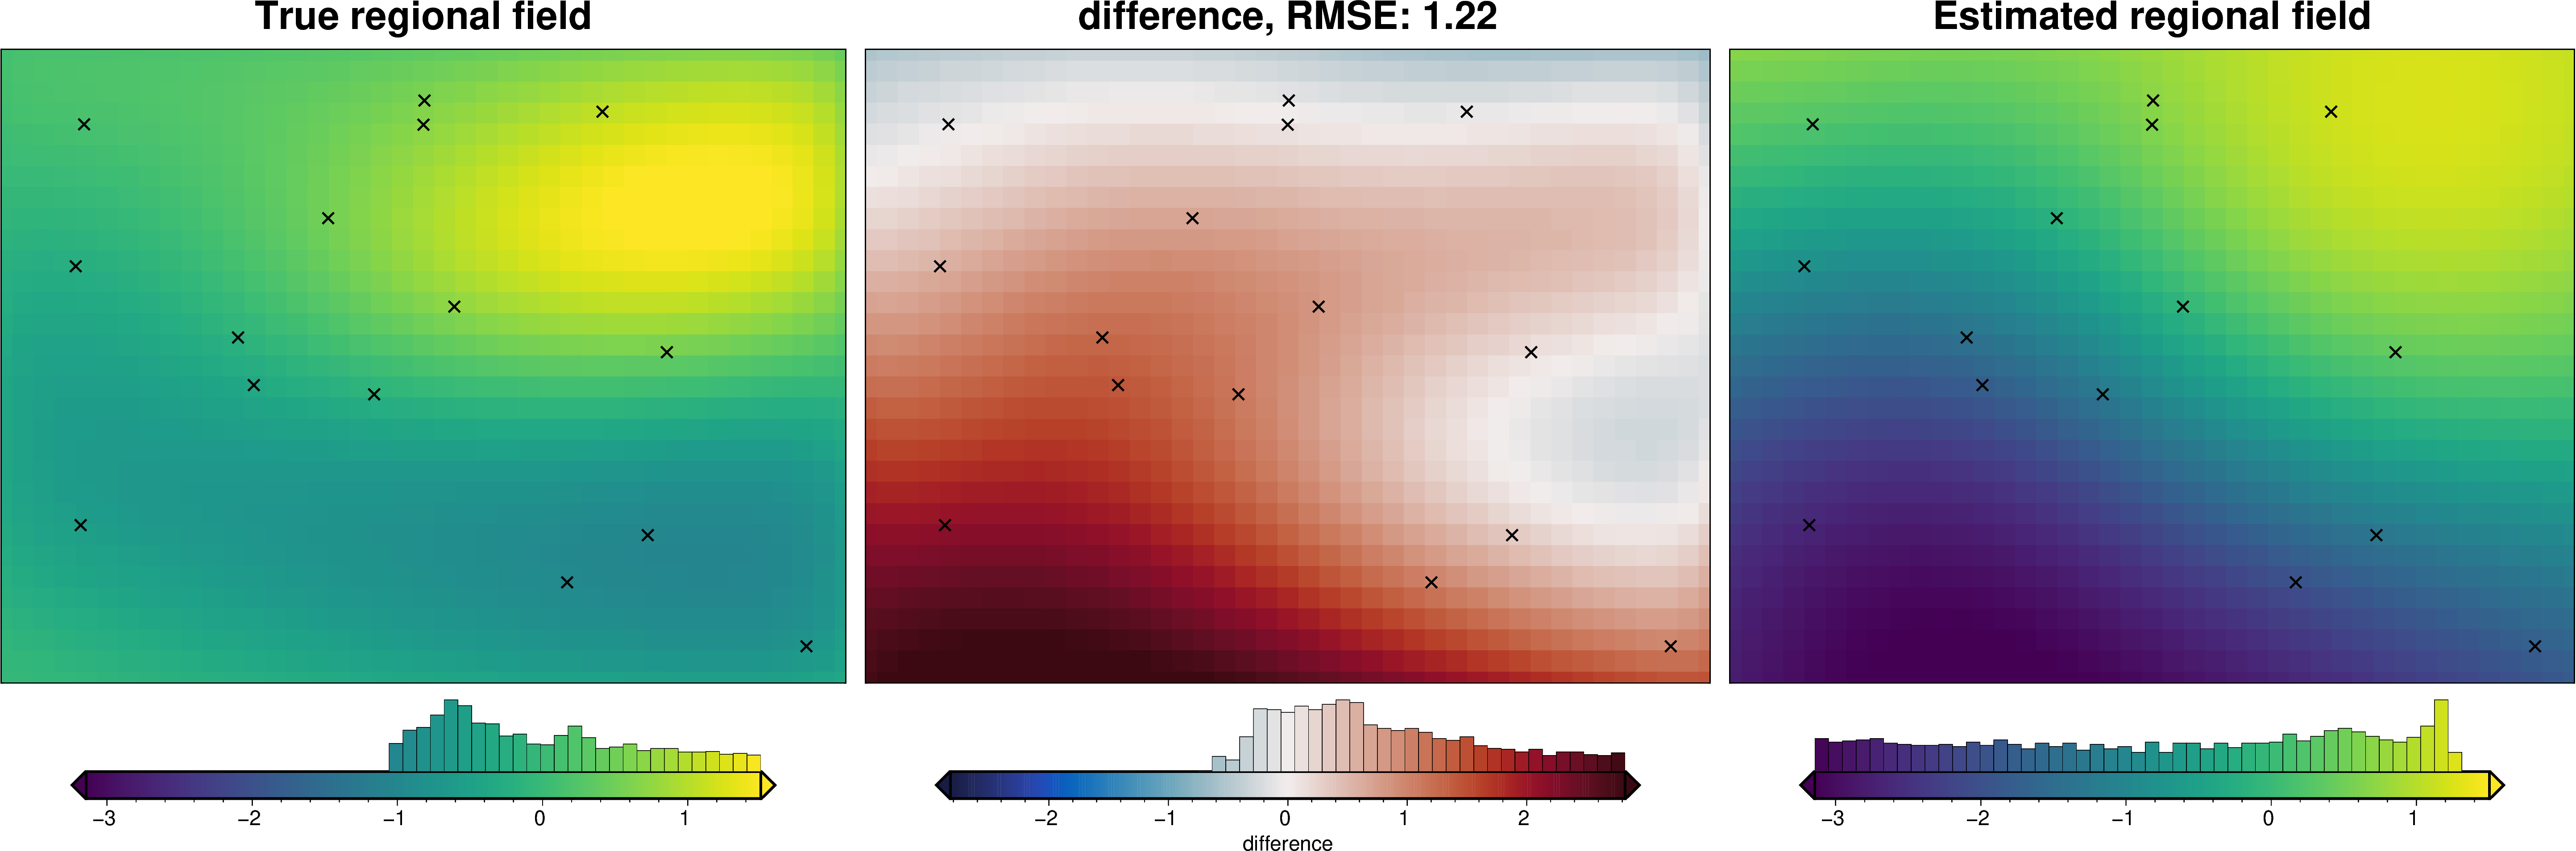

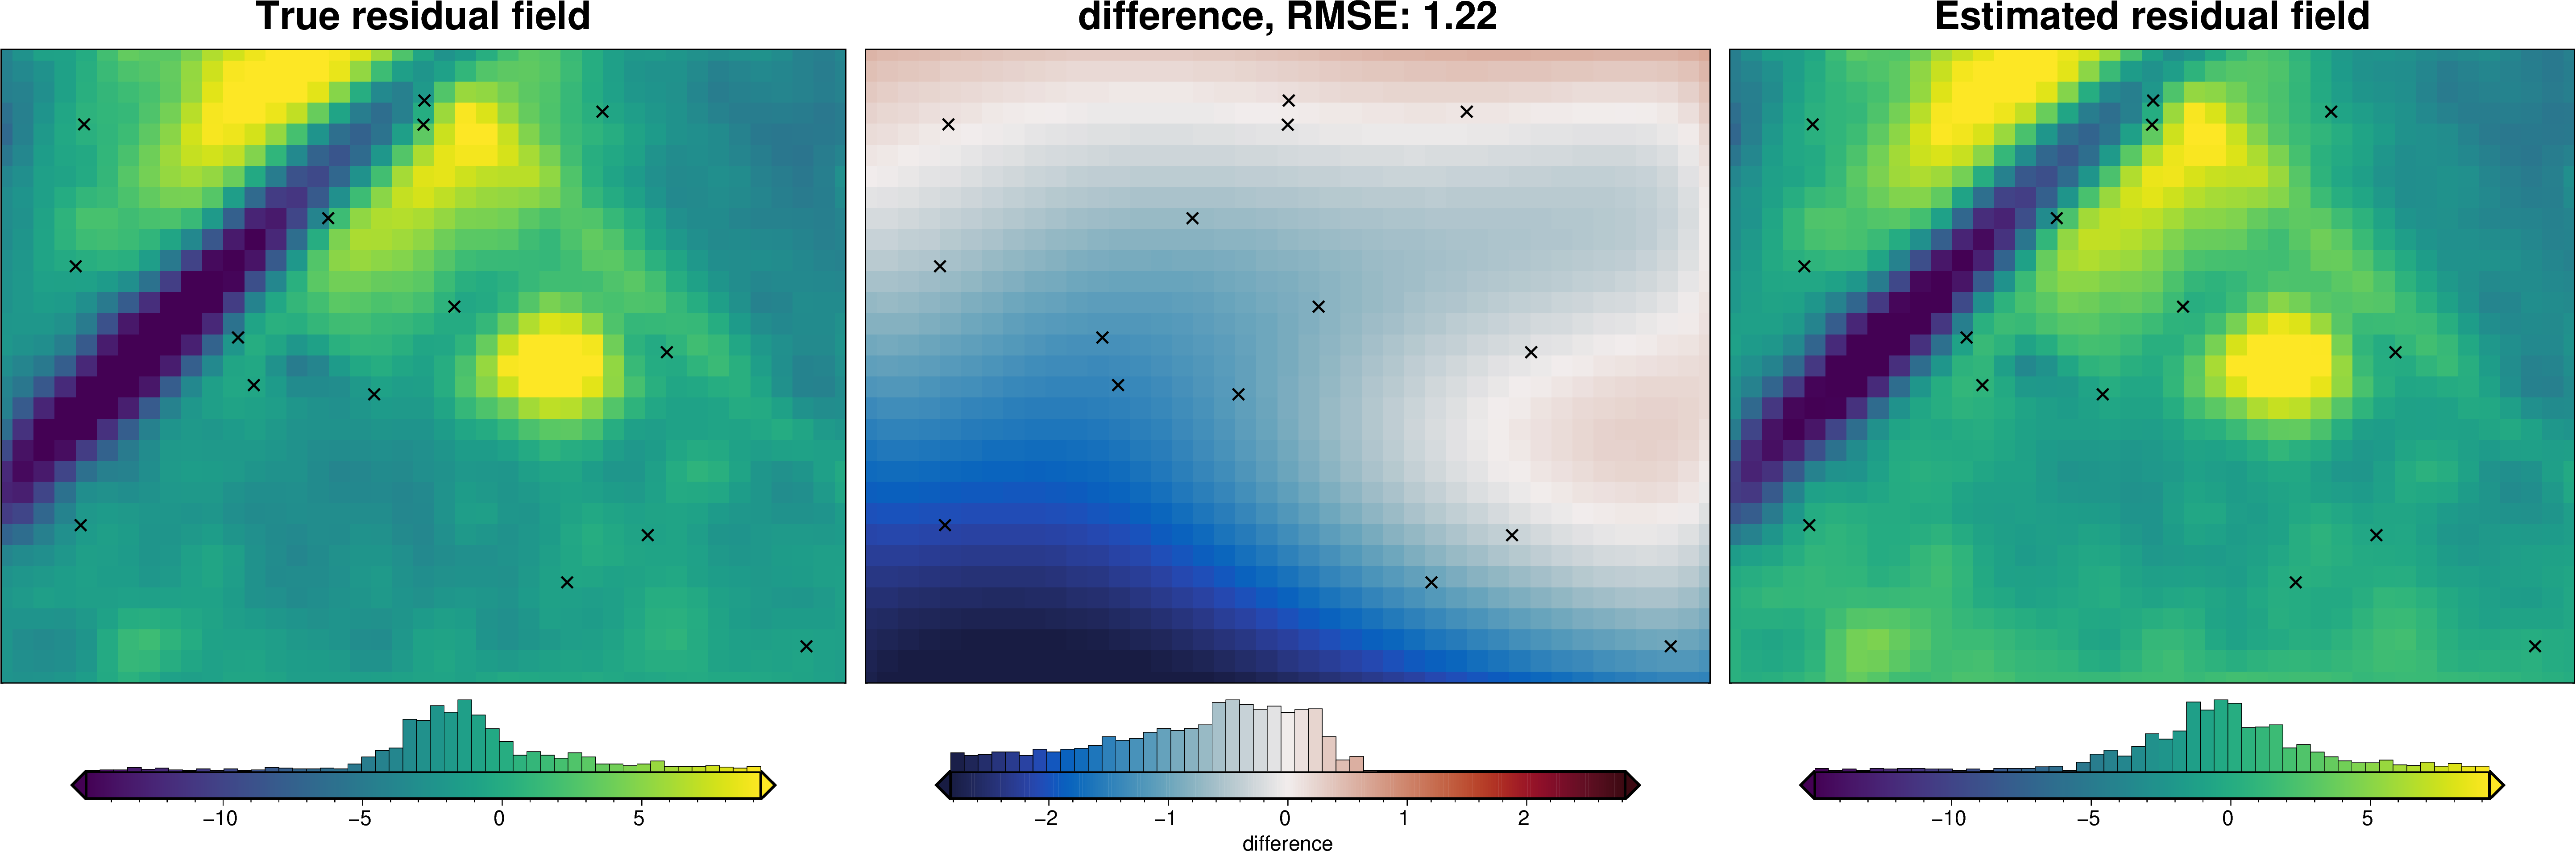

,northing,easting,upward,upper_surface_grav,lower_surface_grav,observed_grav,gravity_anomaly,uncert,starting_gravity,true_res,misfit,reg,res
count,1271.000000,1271.00000,1271.0,1271.000000,1271.000000,1271.000000,1271.000000,1.271000e+03,1271.000000,1271.000000,1271.000000,1271.000000,1271.000000
mean,15000.000000,20000.00000,1001.0,-0.128924,0.004007,-0.124917,-0.124917,1.000000e-01,1.130048,-1.258972,-1.254965,-0.826202,-0.428763
std,8947.792584,11836.81698,0.0,7.128555,0.714063,7.271000,7.269461,2.776650e-17,6.906876,4.602393,4.828938,1.381263,4.468367
min,0.000000,0.00000,1001.0,-17.179165,-1.033526,-16.887668,-17.040892,1.000000e-01,-8.029374,-19.592048,-19.972714,-3.252846,-18.401579
25%,7000.000000,10000.00000,1001.0,-5.448852,-0.601914,-5.750137,-5.739415,1.000000e-01,-4.384273,-3.001265,-3.103593,-2.061162,-2.179133
50%,15000.000000,20000.00000,1001.0,-1.160222,-0.153040,-0.758131,-0.713654,1.000000e-01,-0.620986,-1.444045,-1.845960,-0.728823,-0.376701
75%,23000.000000,30000.00000,1001.0,3.675021,0.541706,3.825804,3.815224,1.000000e-01,5.463603,0.461464,0.793943,0.449287,1.566782
max,30000.000000,40000.00000,1001.0,19.599674,1.599823,19.781652,19.936108,1.000000e-01,23.315668,13.969990,14.301613,1.237070,14.384714


In [15]:
# estimate regional with the mean misfit at constraints
regional_grav_kwargs = dict(
    method="constraints",
    grid_method="eq_sources",
    constraints_df=constraint_points,
    constraints_weights_column="weight",
    cv=True,
    cv_kwargs=dict(
        n_trials=50,
        damping_limits=(1e-10, 1),
        # depth_limits=(1e3,100e3),
        progressbar=False,
        fname="../tmp/regional_sep",
        # plot=True,
    ),
    depth="default",
    block_size=None,
)

grav_df = regional.regional_separation(
    grav_df=grav_df,
    **regional_grav_kwargs,
)

regional_comparison(grav_df)
grav_df.describe()

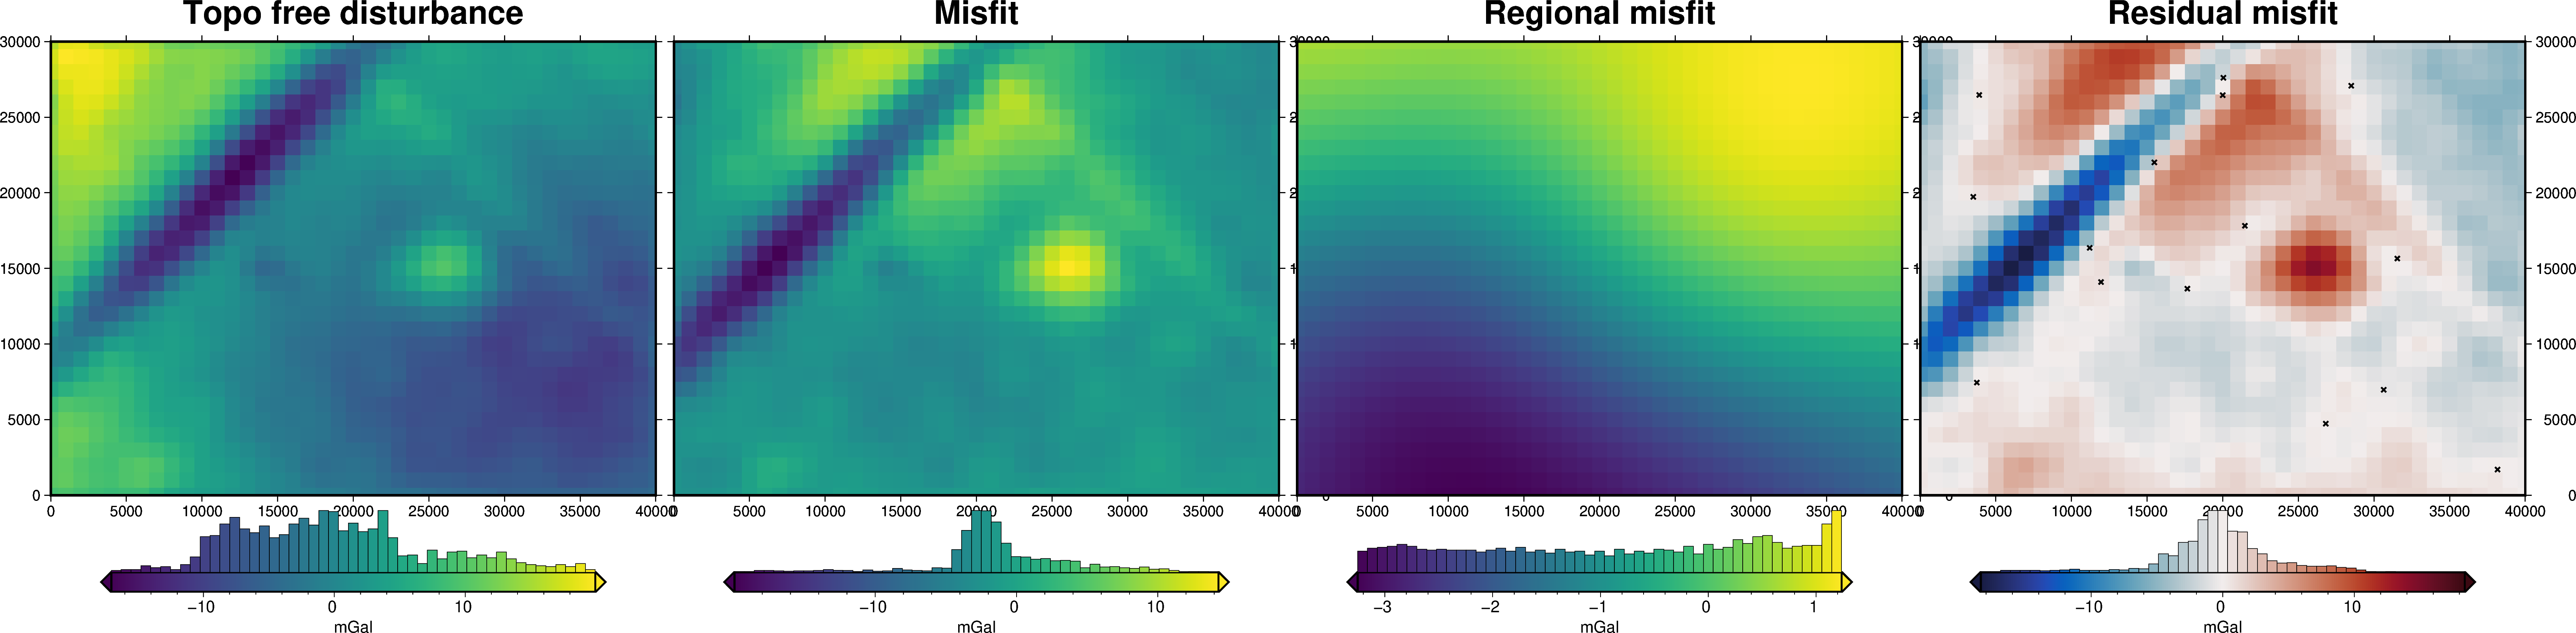

In [16]:
grav_grid = grav_df.set_index(["northing", "easting"]).to_xarray()

fig = maps.plot_grd(
    grav_grid.gravity_anomaly,
    fig_height=10,
    title="Topo free disturbance",
    cmap="viridis",
    hist=True,
    cbar_label="mGal",
    frame=["nSWe", "xaf10000", "yaf10000"],
)

fig = maps.plot_grd(
    grav_grid.misfit,
    fig=fig,
    origin_shift="x",
    fig_height=10,
    title="Misfit",
    cmap="viridis",
    hist=True,
    cbar_label="mGal",
    frame=["nSwE", "xaf10000", "yaf10000"],
)

fig = maps.plot_grd(
    grav_grid.reg,
    fig=fig,
    origin_shift="x",
    fig_height=10,
    title="Regional misfit",
    cmap="viridis",
    hist=True,
    cbar_label="mGal",
    frame=["nSwE", "xaf10000", "yaf10000"],
)

fig = maps.plot_grd(
    grav_grid.res,
    fig=fig,
    origin_shift="x",
    fig_height=10,
    title="Residual misfit",
    cmap="balance+h0",
    cpt_lims=[-vd.maxabs(grav_grid.res), vd.maxabs(grav_grid.res)],
    hist=True,
    cbar_label="mGal",
    frame=["nSwE", "xaf10000", "yaf10000"],
    points=constraint_points,
    points_style="x.15c",
)
fig.show()

## Single inversion
Perform a single inversion to experiment with values of stopping criteria.

In [17]:
# set kwargs to pass to the inversion
kwargs = {
    # set stopping criteria
    "max_iterations": 200,
    "l2_norm_tolerance": 0.3,  # grav error of .1mGal -> sqrt(.1) = 0.3
    "delta_l2_norm_tolerance": 1.008,
}

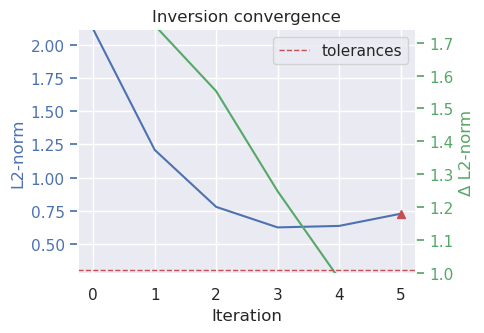

In [18]:
# run the inversion workflow, including a cross validation for the damping parameter
inversion_results = inversion.run_inversion_workflow(
    grav_df=grav_df,
    solver_damping=0.005,
    fname="../tmp/combining_it_all",
    starting_prisms=starting_prisms,
    plot_dynamic_convergence=True,
    **kwargs,
)

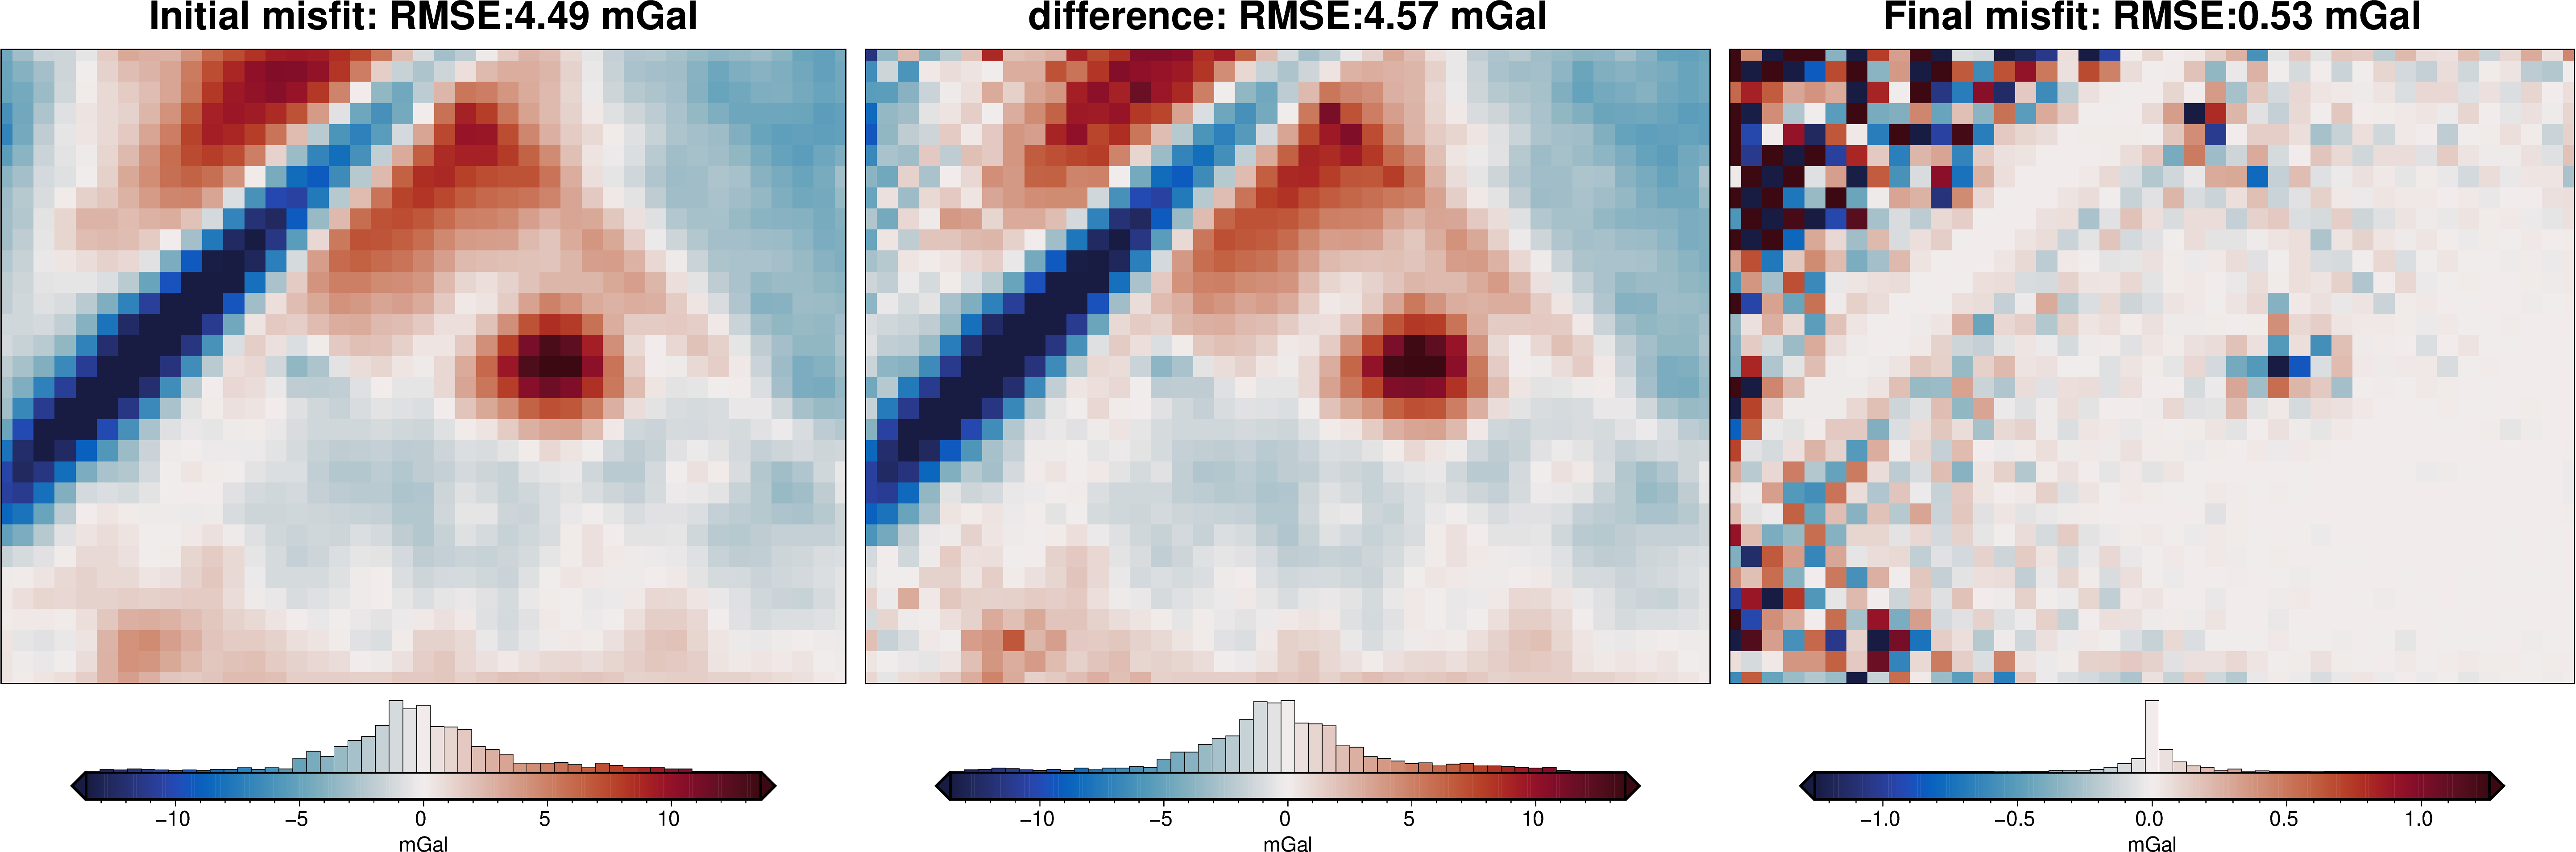

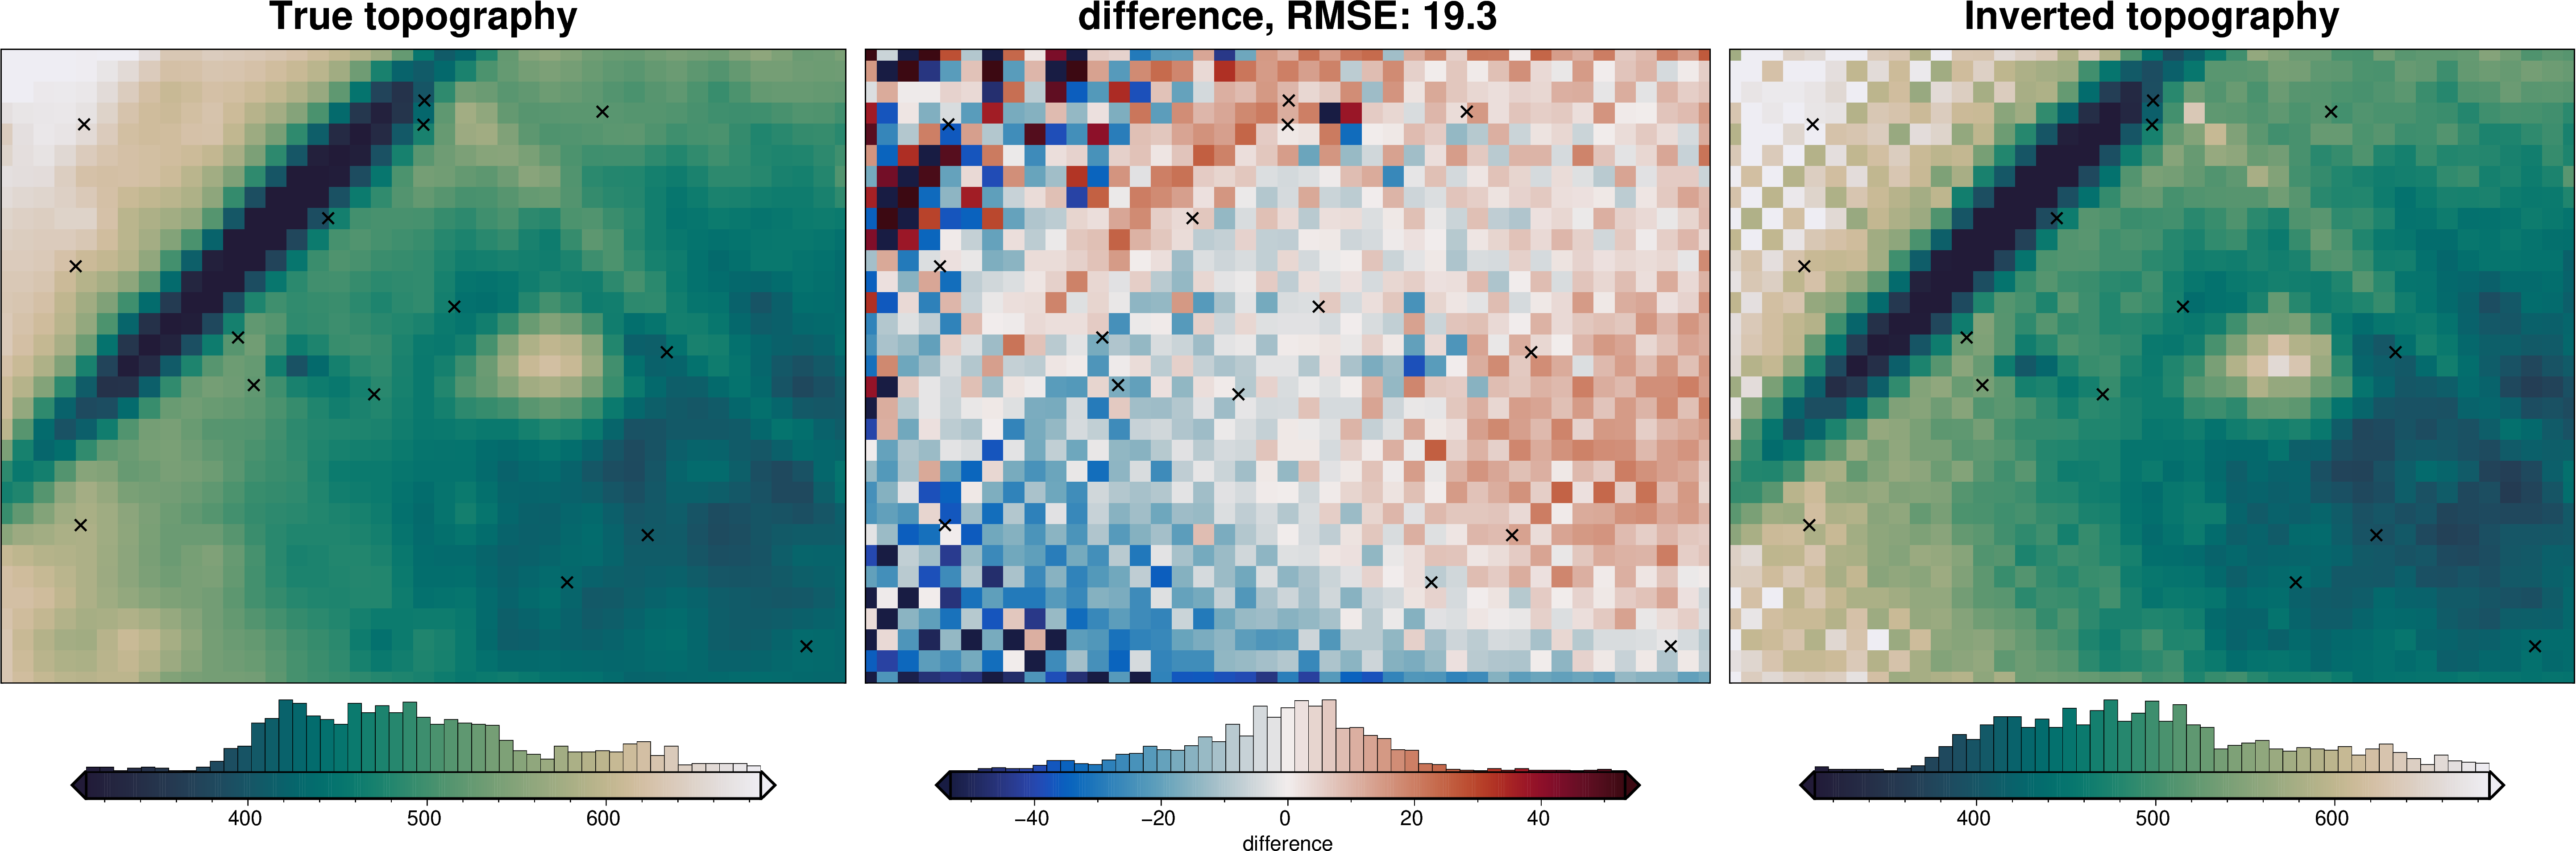

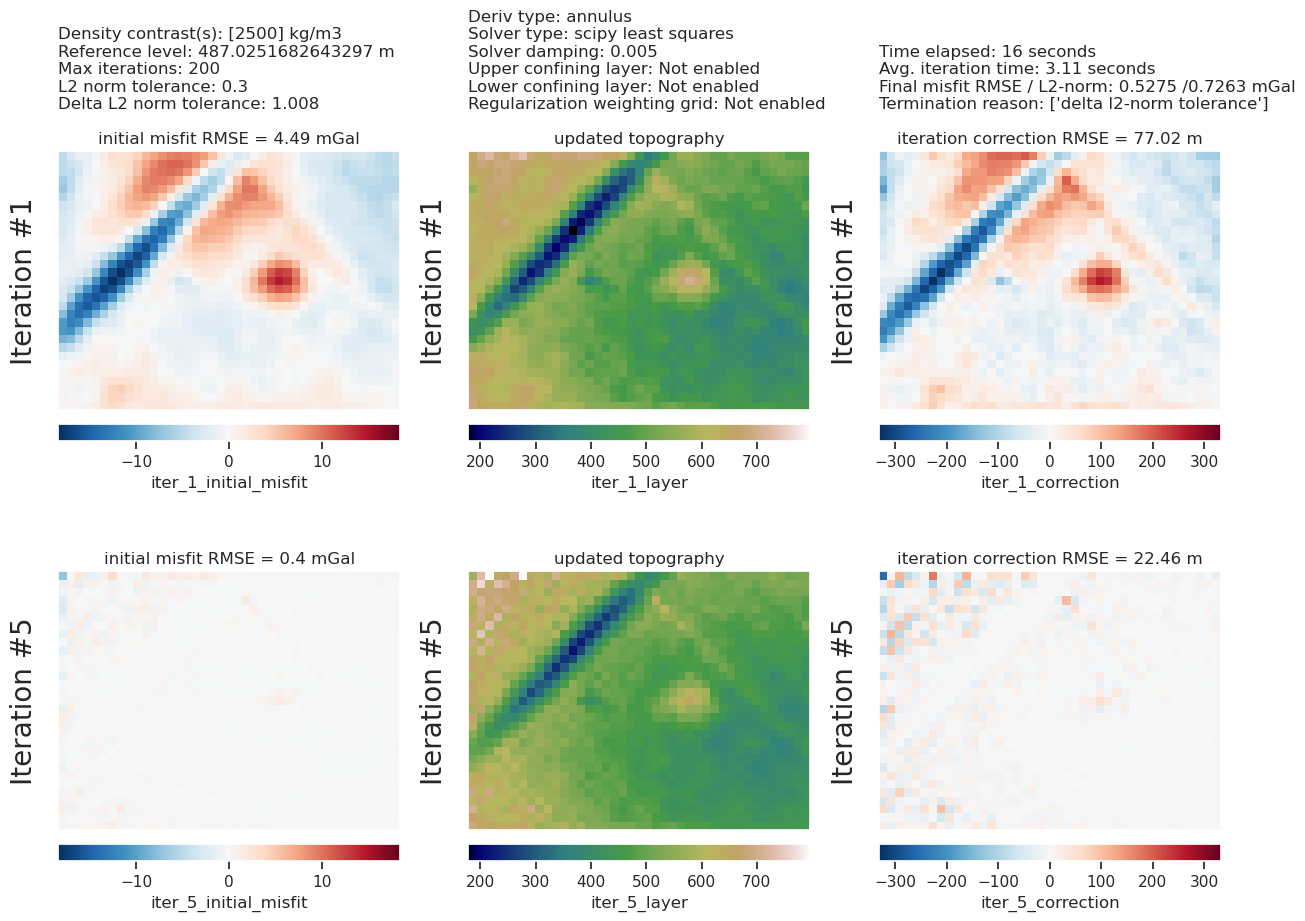

In [19]:
# collect the results
topo_results, grav_results, parameters, elapsed_time = inversion_results

plotting.plot_inversion_results(
    grav_results,
    topo_results,
    parameters,
    region,
    iters_to_plot=2,
    plot_iter_results=True,
    plot_topo_results=False,
    plot_grav_results=True,
)

final_topography = topo_results.set_index(["northing", "easting"]).to_xarray().topo

_ = polar_utils.grd_compare(
    true_topography,
    final_topography,
    grid1_name="True topography",
    grid2_name="Inverted topography",
    robust=True,
    hist=True,
    title="difference",
    grounding_line=False,
    reverse_cpt=True,
    cmap="rain",
    points=constraint_points,
    points_style="x.3c",
)

## Damping parameter cross validation

### Resample to create testing / training data sets

In [20]:
# resample to half spacing
grav_df = cross_validation.resample_with_test_points(spacing, grav_df, region)
grav_df

,northing,easting,test,upward,upper_surface_grav,lower_surface_grav,observed_grav,gravity_anomaly,uncert,starting_gravity,true_res,misfit,reg,res
0,0.0,0.0,False,1001.0,9.042402,-0.041223,9.001179,9.017793,0.1,11.408351,-2.349335,-2.390558,-2.794316,0.403757
1,0.0,500.0,True,1001.0,9.380272,-0.046312,9.333959,9.331242,0.1,11.909467,-2.531914,-2.578226,-2.830267,0.252041
2,0.0,1000.0,False,1001.0,9.568091,-0.052122,9.515969,9.506800,0.1,12.216886,-2.657964,-2.710087,-2.865697,0.155610
3,0.0,1500.0,True,1001.0,9.298147,-0.059918,9.238228,9.269420,0.1,11.954939,-2.625601,-2.685519,-2.899871,0.214352
4,0.0,2000.0,False,1001.0,8.893385,-0.068787,8.824597,8.892680,0.1,11.475842,-2.514374,-2.583162,-2.932917,0.349755
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4936,30000.0,38000.0,False,1001.0,2.982330,0.607664,3.589994,3.623280,0.1,7.275366,-4.259751,-3.652086,1.155233,-4.807320
4937,30000.0,38500.0,True,1001.0,2.931601,0.580987,3.512587,3.472411,0.1,7.420455,-4.529030,-3.948043,1.142642,-5.090685
4938,30000.0,39000.0,False,1001.0,2.946999,0.545480,3.492479,3.401948,0.1,7.429615,-4.573146,-4.027666,1.129090,-5.156755
4939,30000.0,39500.0,True,1001.0,2.873747,0.495910,3.369657,3.335928,0.1,7.089355,-4.249337,-3.753427,1.114440,-4.867867


INFO:invert4geom:using 4 startup trials


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

INFO:invert4geom:Trial with best score: 


INFO:invert4geom:	trial number: 4


INFO:invert4geom:	parameter: {'damping': 0.02239318117126179}


INFO:invert4geom:	scores: [0.09018773530362258]


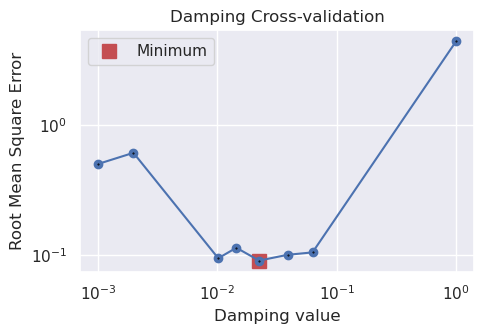

In [21]:
damping_study, inversion_results = optimization.optimize_inversion_damping(
    training_df=grav_df[grav_df.test == False],
    testing_df=grav_df[grav_df.test == True],
    prism_layer=starting_prisms,
    damping_limits=(0.001, 1),
    n_trials=8,
    fname="../tmp/combining_it_all_damping_CV",
    **kwargs,
)

In [22]:
# re-load the study from the saved pickle file
with pathlib.Path("../tmp/combining_it_all_damping_CV_study.pickle").open("rb") as f:
    damping_study = pickle.load(f)

# re-load the inversion results from the saved pickle file
with pathlib.Path("../tmp/combining_it_all_damping_CV_results.pickle").open("rb") as f:
    inversion_results = pickle.load(f)

In [23]:
best_damping = damping_study.best_params.get("damping")
best_damping

0.02239318117126179

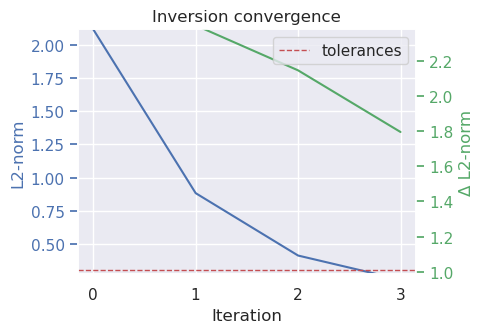

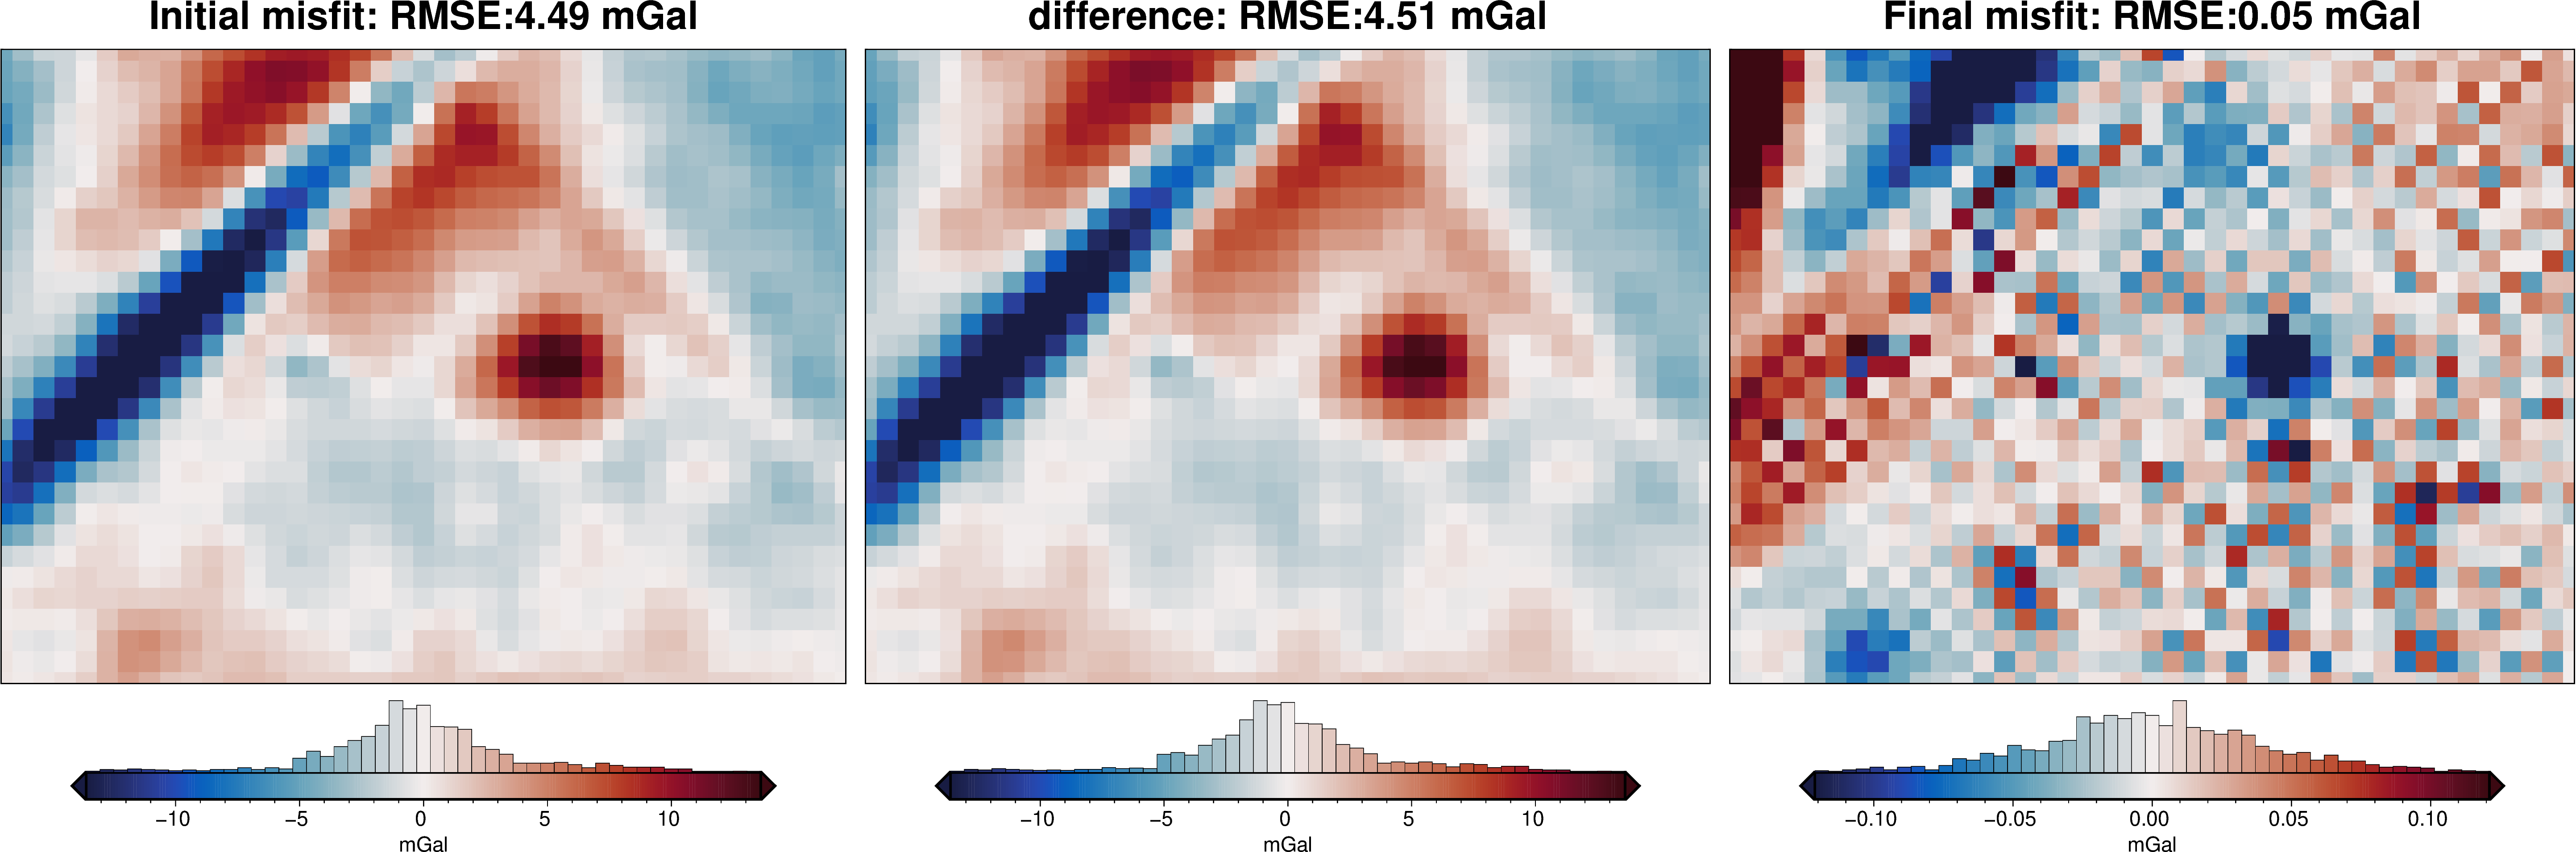

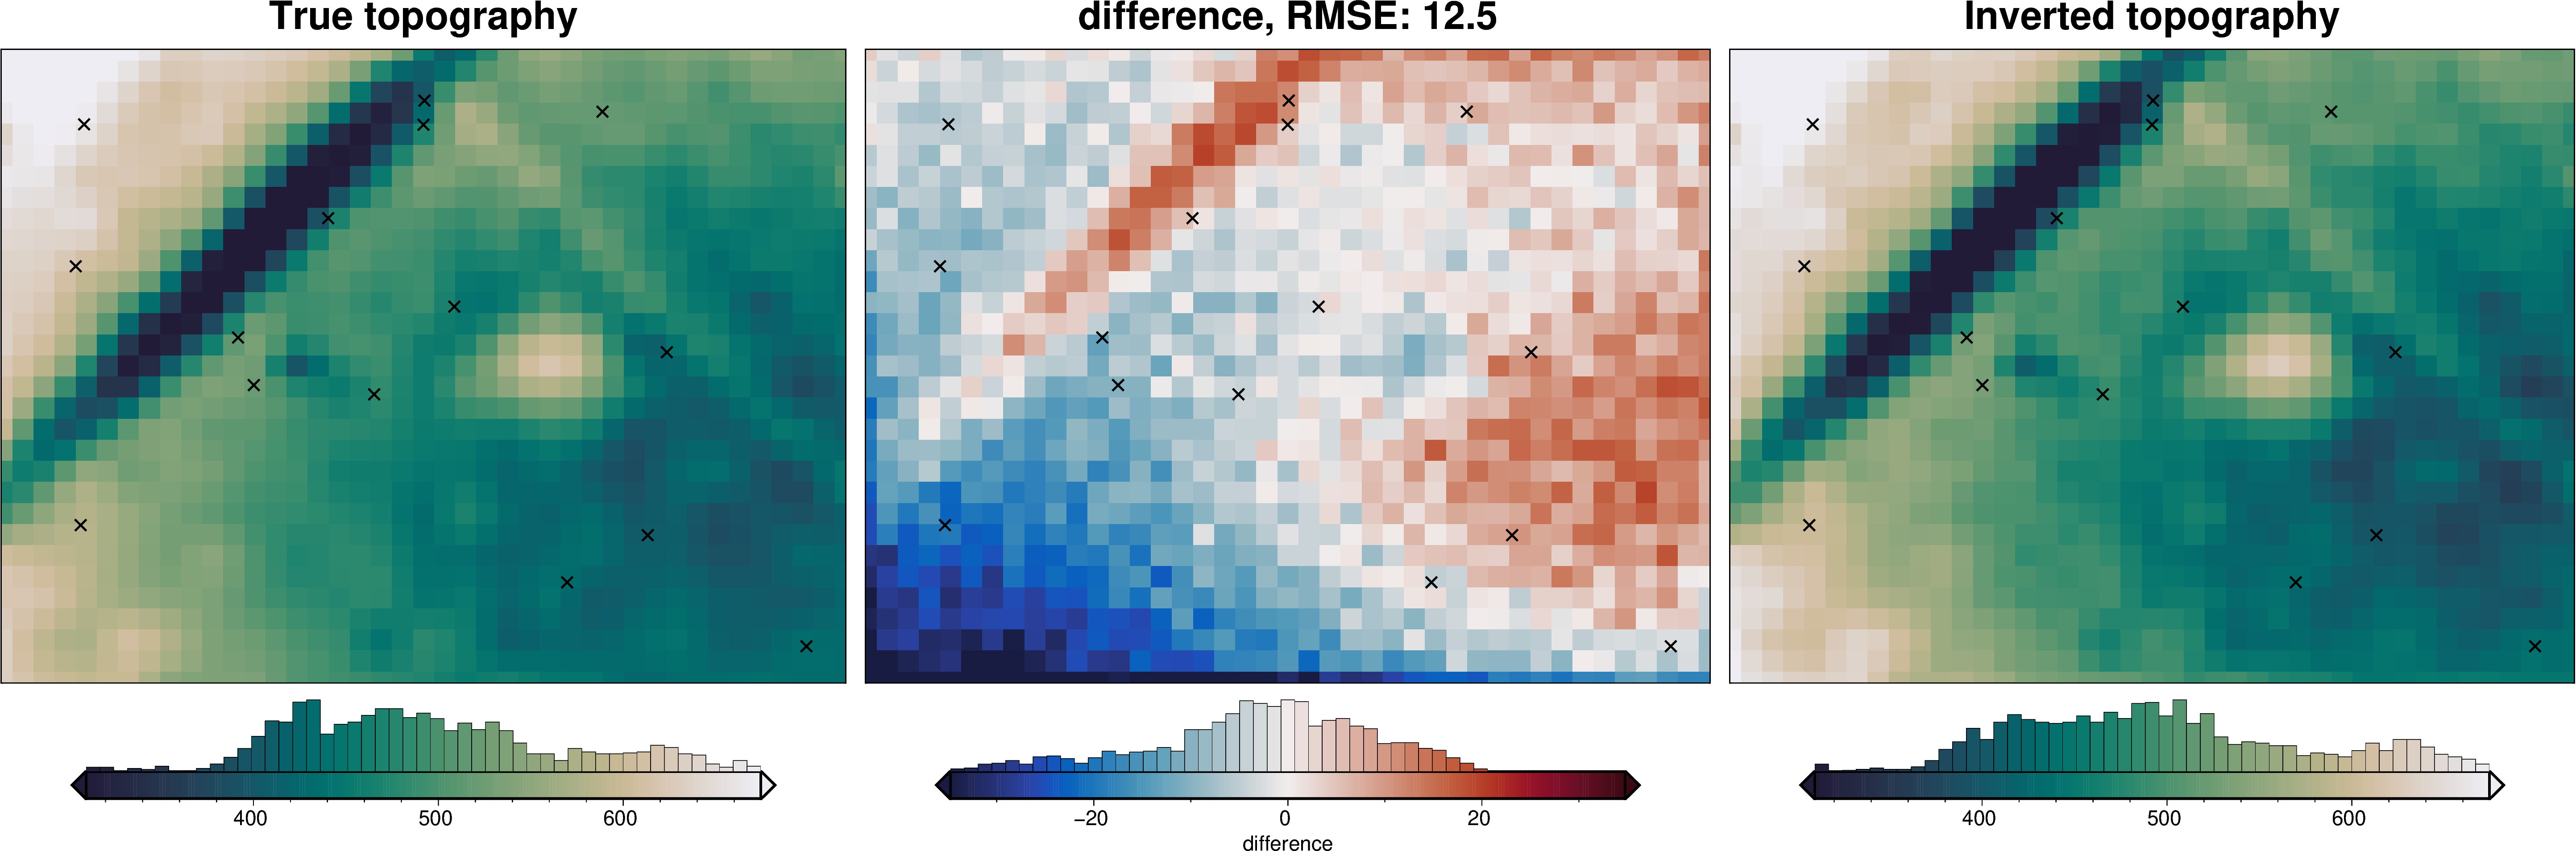

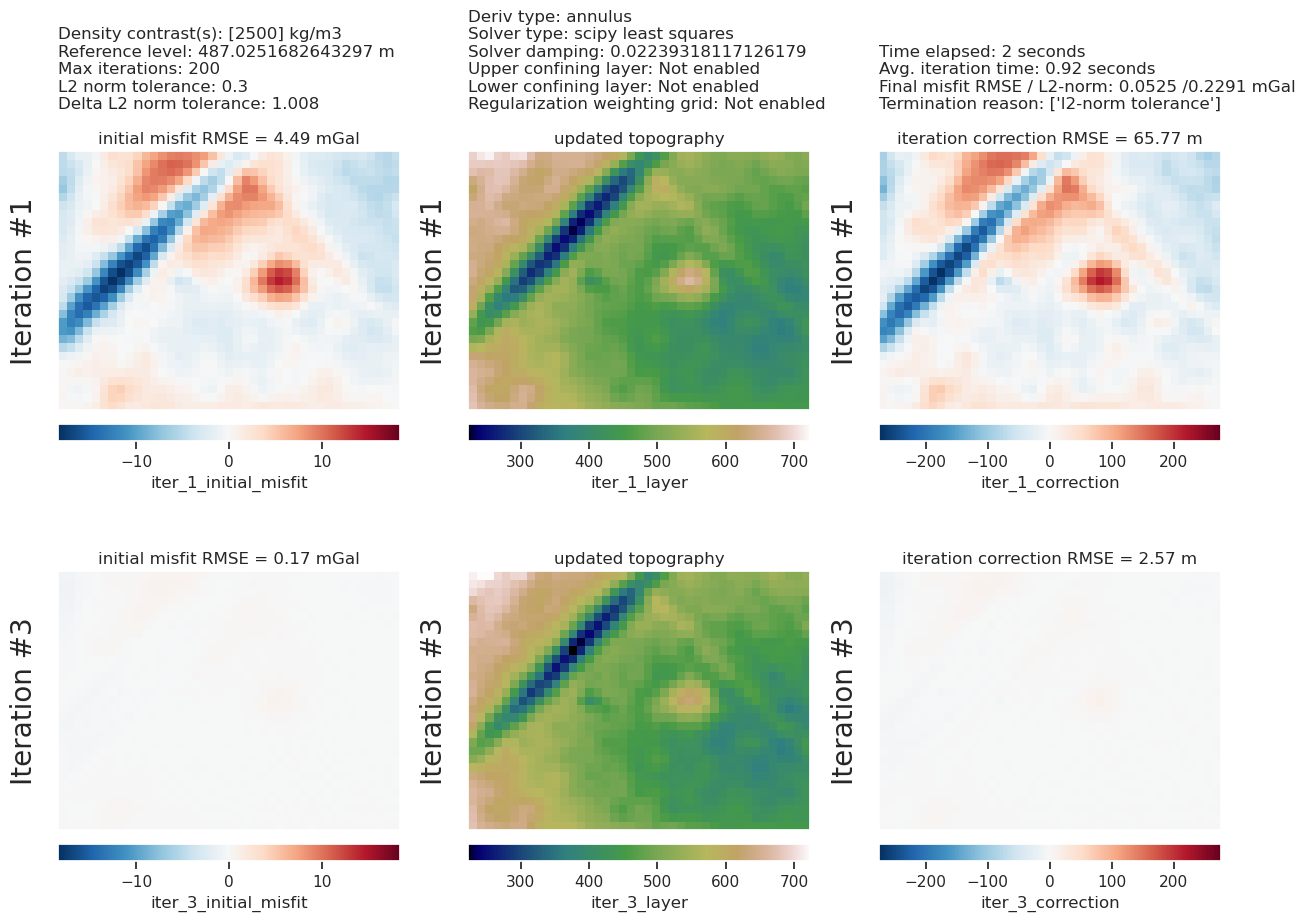

In [24]:
# collect the results
topo_results, grav_results, parameters, elapsed_time = inversion_results

plotting.plot_convergence(
    grav_results,
    params=parameters,
)

plotting.plot_inversion_results(
    grav_results,
    topo_results,
    parameters,
    region,
    iters_to_plot=2,
    plot_iter_results=True,
    plot_topo_results=False,
    plot_grav_results=True,
)

final_topography = topo_results.set_index(["northing", "easting"]).to_xarray().topo

_ = polar_utils.grd_compare(
    true_topography,
    final_topography,
    grid1_name="True topography",
    grid2_name="Inverted topography",
    robust=True,
    hist=True,
    title="difference",
    grounding_line=False,
    reverse_cpt=True,
    cmap="rain",
    points=constraint_points,
    points_style="x.3c",
)

In [25]:
# sample the inverted topography at the constraint points
constraint_points = utils.sample_grids(
    constraint_points,
    final_topography,
    "inverted_topography",
)

rmse = utils.rmse(constraint_points.upward - constraint_points.inverted_topography)
print(f"RMSE: {rmse:.2f} m")

RMSE: 12.15 m


## Density contrast cross validation
Since this cross validation uses the inversion error at constraint points, we can't use the constraint point minimization technique to estimate the regional field since that inherently sets the inversion error at constraints to zero, invalidating the cross validation scores. 

There are two options for how to get around this issue:
1) use a different regional estimation technique while finding the optimal density contrast value, then use the found optimal values with the constraint point minimization regional estimation technique afterwards. 
2) separate the constraints into testing and training sets, so that only the training set is used during the regional separation, and only the testing set is used for scoring the density contrast cross validation. 

Since we have constraint points, we will just use their mean value as the zref and omit the zref CV. 

Well perform both methods below:

In [26]:
# # we don't need the testing points anymore
# grav_df = grav_df[grav_df.test == False].copy()
# grav_df = grav_df.drop(columns=["test"])
# grav_df

### 1) Use alternative regional estimation method

We will use the equivalent sources technique to estimate the regional field, and then perform a cross-validation for the density contrast. During this CV, we will use the optimal damping parameter value found above. Once we have found the optimal density contrast value, we will need to use then in a separate inversion which had the regional field estimated with the better constraint point minimization technique.

In [27]:
# grav_df = regional.regional_separation(
#     grav_df=grav_df,
#     method="constant",
#     constraints_df=constraint_points,
# )
# regional_comparison(grav_df)

In [28]:
# true_density_contrast, true_zref

#### Density CV

In [29]:
# constraint_points.upward.mean()

In [30]:
# # run the cross validation for the zref
# study, inversion_results = optimization.optimize_inversion_zref_density_contrast(
#     grav_df=grav_df,
#     solver_damping=best_damping,
#     constraints_df=constraint_points,
#     zref=constraint_points.upward.mean(),
#     density_contrast_limits=(2300, 3000),
#     n_trials=8,
#     starting_topography=starting_topography,
#     regional_grav_kwargs=dict(
#         method="constant",
#         constant=0,
#     ),
#     fname="../tmp/combining_it_all_density_cv",
#     **kwargs,
# )

In [31]:
# # to re-load the study from the saved pickle file
# with pathlib.Path("../tmp/combining_it_all_density_cv_study.pickle").open("rb") as f:
#     study = pickle.load(f)

# optimized_density = study.best_params.get("density_contrast", None)

# print(f"Best found density contrast: {optimized_density}")
# print(f"True density contrast: {true_density_contrast}")
# print(f"Error: {np.abs(optimized_density - true_density_contrast)}")

#### with optimal parameters

In [32]:
# # run the inversion workflow, including a cross validation for the damping parameter
# inversion_results = inversion.run_inversion_workflow(
#     grav_df=grav_df,
#     solver_damping=best_damping,
#     # zref=best_zref,
#     zref=constraint_points.upward.mean(),
#     density_contrast=best_density_contrast,
#     fname="../tmp/combining_it_all",
#     create_starting_prisms=True,
#     starting_topography=starting_topography,
#     calculate_regional_misfit=True,
#     plot_dynamic_convergence=True,
#     regional_grav_kwargs=regional_grav_kwargs,  # constraint point minimization
#     **kwargs,
# )

In [33]:
# # collect the results
# topo_results, grav_results, parameters, elapsed_time = inversion_results

# plotting.plot_inversion_results(
#     grav_results,
#     topo_results,
#     parameters,
#     region,
#     iters_to_plot=2,
#     plot_iter_results=True,
#     plot_topo_results=False,
#     plot_grav_results=True,
# )

# final_topography = topo_results.set_index(["northing", "easting"]).to_xarray().topo

# _ = polar_utils.grd_compare(
#     true_topography,
#     final_topography,
#     plot=True,
#     region=region,
#     grid1_name="True topography",
#     grid2_name="Inverted topography",
#     robust=True,
#     hist=True,
#     inset=False,
#     verbose="q",
#     title="difference",
#     grounding_line=False,
#     reverse_cpt=True,
#     cmap="rain",
#     points=constraint_points,
#     points_style="x.3c",
# )

### 2) K-Folds CV with constraint point minimization
This option is less efficient, but in some cases may be more accurate. 

Perform a cross validation for the optimal zref and density contrast values same as
function `optimize_inversion_zref_density_contrast`, but pass a dataframe of
constraint points which contains folds of testing and training data (generated with
`cross_validation.split_test_train`). For each set of zref/density values, recreate the 
starting topography with the supplied `starting_topography_kwargs`, recreate the 
starting prism model, and perform a regional separation and inversion for each of the 
K folds in the constraints dataframe. 

After all K folds are inverted, the mean of the K folds scores will be
the score for that set of parameters. Repeat this for all parameters. Within each
fold, the training constraints are used for the regional separation and the testing
constraints are used for scoring. This is only useful if the regional separation
technique you supply via `regional_grav_kwargs` uses constraints points
for the estimations, such as constraint point minimization. If using 20 sets of
density and zref values, and use 5 folds, this will run 100 inversions. It is more
efficient, but less accurate, to simple use a different regional estimation
technique, which doesn't require constraint points, to find the optimal zref and
density values. Then use these again in another inversion with the desired regional
separation technique.

#### Density CV

In [34]:
# run a 5-fold cross validation for 8 parameter sets of density
# this performs 40 inversions and for each one create the starting topography from the
# training constraints, calculated the gravity misfit, performs the regional separation,
# then then performs the inversion.
# study, inversion_results = optimization.optimize_inversion_zref_density_contrast_kfolds( # noqa: E501
#     constraints_df=constraint_points,
#     grav_df=grav_df,
#     solver_damping=best_damping,
#     density_contrast_limits=(2300, 3000),
#     zref=constraint_points.upward.mean(),
#     n_trials=8,
#     starting_topography_kwargs=starting_topography_kwargs,
#     split_kwargs=dict(
#         n_splits=5,
#         method="KFold",
#     ),
#     regional_grav_kwargs=regional_grav_kwargs,
#     fname="../tmp/combining_it_all_density_cv_with_cpm_kfolds",
#     fold_progressbar=True,
#     **kwargs,
# )

In [35]:
# # to re-load the study from the saved pickle file
# with pathlib.Path(
#     "../tmp/combining_it_all_density_cv_with_cpm_kfolds_study.pickle"
# ).open("rb") as f:
#     study = pickle.load(f)

# # to re-load the inversion results from the saved pickle file
# with pathlib.Path(
#     "../tmp/combining_it_all_density_cv_with_cpm_kfolds_results.pickle"
# ).open("rb") as f:
#     inversion_results = pickle.load(f)

In [36]:
# kfold_optimized_density = study.best_params.get("density_contrast")

# print(f"Best found density contrast: {kfold_optimized_density}")
# print(f"True density contrast: {true_density_contrast}")
# print(f"Error: {np.abs(kfold_optimized_density - true_density_contrast)}")

In [37]:
# # collect the results
# topo_results, grav_results, parameters, elapsed_time = inversion_results

# plotting.plot_inversion_results(
#     grav_results,
#     topo_results,
#     parameters,
#     region,
#     iters_to_plot=2,
#     plot_iter_results=True,
#     plot_topo_results=False,
#     plot_grav_results=False,
# )

# final_topography = topo_results.set_index(["northing", "easting"]).to_xarray().topo

# _ = polar_utils.grd_compare(
#     true_topography,
#     final_topography,
#     plot=True,
#     grid1_name="True topography",
#     grid2_name="Inverted topography",
#     robust=True,
#     hist=True,
#     inset=False,
#     verbose="q",
#     title="difference",
#     grounding_line=False,
#     reverse_cpt=True,
#     cmap="rain",
#     points=constraint_points,
#     points_style="x.3c",
# )

In [38]:
# # sample the inverted topography at the constraint points
# constraint_points = utils.sample_grids(
#     constraint_points,
#     final_topography,
#     "inverted_topography",
# )

# rmse = utils.rmse(constraint_points.upward - constraint_points.inverted_topography)
# print(f"RMSE: {rmse:.2f} m")

In [39]:
# print("optimal density contrast from normal optimization: ", optimized_density)
# print("optimal density contrast from K-folds optimization: ", kfold_optimized_density)
# print("real density contrast", true_density_contrast)

# best_density_contrast = min(
#     [optimized_density, kfold_optimized_density],
#     key=lambda x: abs(x - true_density_contrast),
# )
# print("Best density contrast: ", best_density_contrast)

## Z-ref cross validation

In [40]:
# # run the cross validation for the zref
# study, inversion_results = optimization.optimize_inversion_zref_density_contrast(
#     grav_df=grav_df,
#     solver_damping=best_damping,
#     constraints_df=constraint_points,
#     zref_limits=(0, 1000),
#     density_contrast=best_density_contrast,
#     n_trials=8,
#     starting_topography=starting_topography,
#     regional_grav_kwargs=dict(
#         method="constant",
#         constant=0,
#     ),
#     fname="../tmp/combining_it_all_zref_cv",
#     **kwargs,
# )

In [41]:
# print(
#     f"True zref value: {true_zref}, "
#     f"best zref from CV: {study.best_params.get("zref")}"
# )

## Z-ref and density contrast optimizations

In [ ]:
# run the cross validation for the zref and density
study, inversion_results = optimization.optimize_inversion_zref_density_contrast(
    grav_df=grav_df,
    constraints_df=constraint_points,
    solver_damping=best_damping,
    density_contrast_limits=(2300, 3000),
    zref_limits=(0, 1e3),
    n_trials=15,
    plot_cv=False,
    starting_topography=starting_topography,
    regional_grav_kwargs={
        "method": "constant",
        "constant": 0,
    },
    fname="../tmp/combining_it_all_density_and_zref_cv",
    **kwargs,
)

In [6]:
# to re-load the study from the saved pickle file
with pathlib.Path("../tmp/combining_it_all_density_and_zref_cv_study.pickle").open(
    "rb"
) as f:
    study = pickle.load(f)

# to re-load the inversion results from the saved pickle file
with pathlib.Path("../tmp/combining_it_all_density_and_zref_cv_results.pickle").open(
    "rb"
) as f:
    inversion_results = pickle.load(f)

# collect the results
topo_results, grav_results, parameters, elapsed_time = inversion_results

best_zref = study.best_params.get("zref")
best_density_contrast = study.best_params.get("density_contrast")

print(f"True zref value: {true_zref}, " f"best zref from CV: {best_zref}")
print(
    f"True density contrast: {true_density_contrast}, "
    f"best density contrast from CV: {best_density_contrast}"
)

True zref value: 492.2589625197673, best zref from CV: 491.2272026891009
True density contrast: 2669, best density contrast from CV: 2760


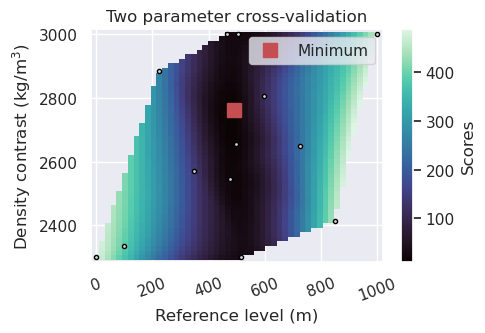

In [7]:
fig = plotting.plot_2_parameter_cv_scores_uneven(
    study,
    param_names=(
        "params_zref",
        "params_density_contrast",
    ),
    plot_param_names=(
        "Reference level (m)",
        "Density contrast (kg/m$^3$)",
    ),
)

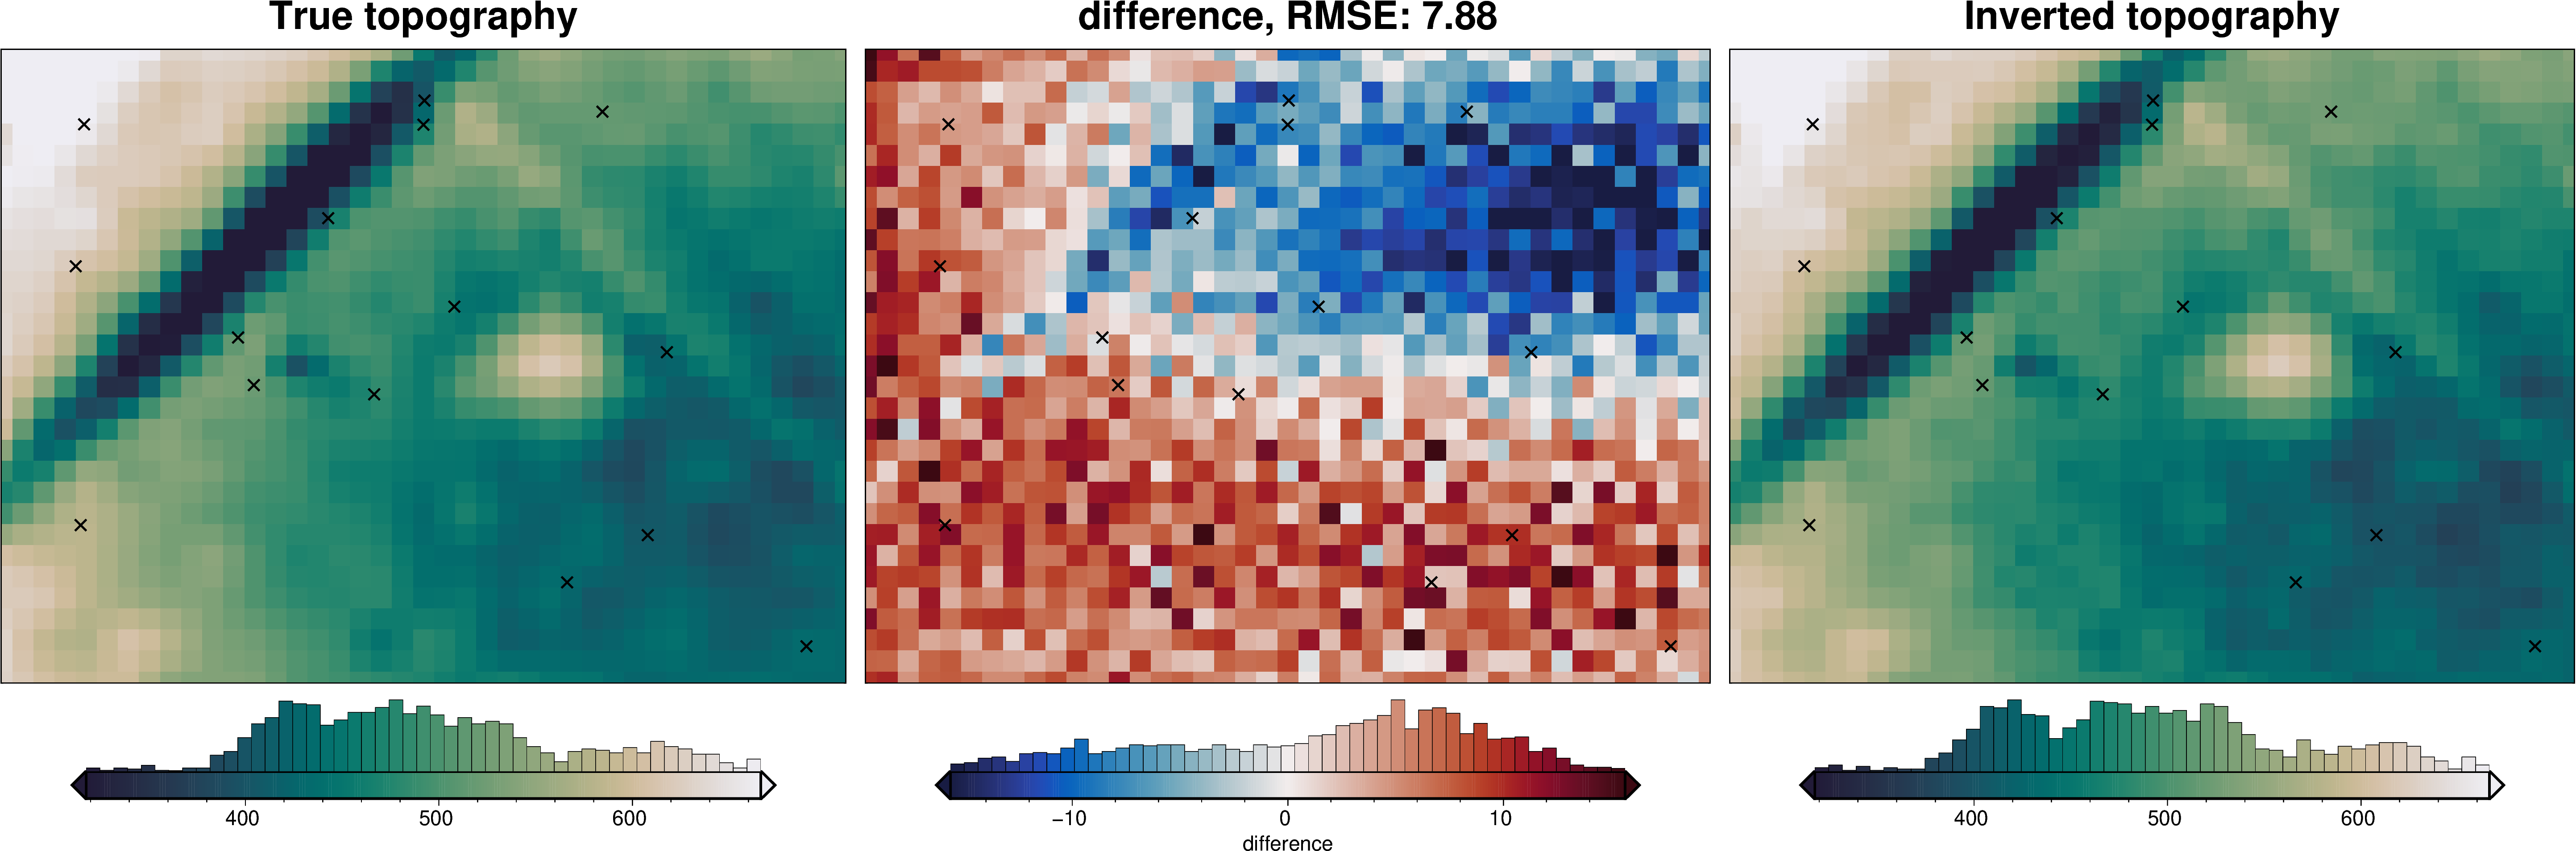

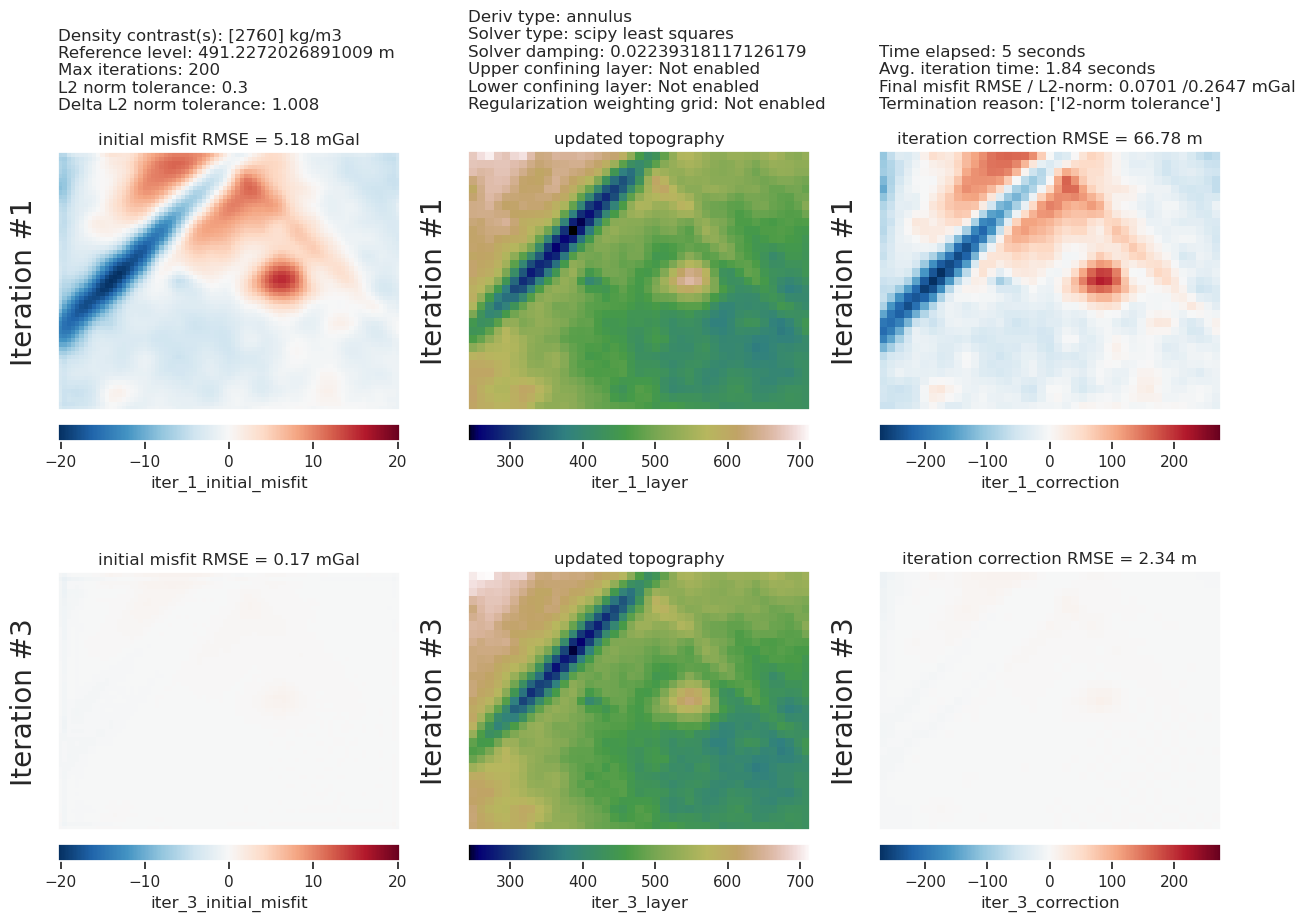

In [44]:
plotting.plot_inversion_results(
    grav_results,
    topo_results,
    parameters,
    region,
    iters_to_plot=2,
    plot_iter_results=True,
    plot_topo_results=False,
    plot_grav_results=False,
)

final_topography = topo_results.set_index(["northing", "easting"]).to_xarray().topo

_ = polar_utils.grd_compare(
    true_topography,
    final_topography,
    grid1_name="True topography",
    grid2_name="Inverted topography",
    robust=True,
    hist=True,
    title="difference",
    grounding_line=False,
    reverse_cpt=True,
    cmap="rain",
    points=constraint_points,
    points_style="x.3c",
)

## Save all data

We'll use the results from the first method of density constrast estimation since it performed better.

The notebook `Uncertainty analysis` will use all of the results from this notebook.

In [45]:
# # to re-load the inversion results from the saved pickle file
# with pathlib.Path("../tmp/combining_it_all_results.pickle").open("rb") as f:
#     inversion_results = pickle.load(f)

# # collect the results
# topo_results, grav_results, parameters, elapsed_time = inversion_results

# plotting.plot_inversion_results(
#     grav_results,
#     topo_results,
#     parameters,
#     region,
#     iters_to_plot=2,
#     plot_iter_results=True,
#     plot_topo_results=False,
#     plot_grav_results=True,
# )

# final_topography = topo_results.set_index(["northing", "easting"]).to_xarray().topo

# _ = polar_utils.grd_compare(
#     true_topography,
#     final_topography,
#     plot=True,
#     region=region,
#     grid1_name="True topography",
#     grid2_name="Inverted topography",
#     robust=True,
#     hist=True,
#     inset=False,
#     verbose="q",
#     title="difference",
#     grounding_line=False,
#     reverse_cpt=True,
#     cmap="rain",
#     points=constraint_points,
#     points_style="x.3c",
# )

In [46]:
# merge and save grids
ds = xr.merge(
    [
        true_topography.rename("true"),
        lower_topography.rename("lower"),
        starting_topography.rename("starting"),
        final_topography.rename("inverted"),
    ]
)

fname = "../tmp/combining_it_all_results.pickle"
pathlib.Path(fname).unlink(missing_ok=True)

regional_grav_kwargs.pop("constraints_df", None)

with pathlib.Path(fname).open("ab") as file:
    pickle.dump(grav_df, file, protocol=pickle.HIGHEST_PROTOCOL)
    pickle.dump(constraint_points, file, protocol=pickle.HIGHEST_PROTOCOL)
    pickle.dump(starting_topography_kwargs, file, protocol=pickle.HIGHEST_PROTOCOL)
    pickle.dump(ds, file, protocol=pickle.HIGHEST_PROTOCOL)
    pickle.dump(inversion_results, file, protocol=pickle.HIGHEST_PROTOCOL)
    pickle.dump(kwargs, file, protocol=pickle.HIGHEST_PROTOCOL)
    pickle.dump(regional_grav_kwargs, file, protocol=pickle.HIGHEST_PROTOCOL)
    pickle.dump(starting_prisms, file, protocol=pickle.HIGHEST_PROTOCOL)